This notebook explores the results of inputting CFD dataset images (URL: https://chicagofaces.org/default/ ) into the ML images model.

Explanation:

_The database includes high-resolution photographs of 597 male and
female targets of varying ethnicity. Each target is represented with a neutral
expression photo that has been normed by an independent rater sample.
For a subset of 158 targets, the database also includes photos with the following
facial expressions:_

• happy (with open mouth and visible teeth)

• happy (with closed mouth)

• angry

• fearful

_Not all facial expressions are available for each of these 158 targets.
Norming of the facial expression photos is still in progress._ 



(Jargon: target :=  Face model)

There are 3 data assets:

- Images: (597 targets, 1207 images)
- 'cfd_codebook_annotated.csv': (A 597 x 69 data matrix associating 69 variables with regards to the 597 face models used)
- 'cfd_meta_data.csv': Explanation of the 69 variables mined


**File naming convention:**


- CFD-RaceGender-ImageID-TargetID-Expression.jpg
- Race= {A, B, L, W}
- Gender= {F, M}
- Expression= {N,A,F,HC,HO}

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

First, the imports:

In [2]:
%matplotlib inline
import sys
import numpy as np
import cv2 as cv
import tensorflow as tf
from models import resnet as resnet
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm

Read in the data assets:

In [3]:
data_dir=os.getcwd()+'/data/images/cfd/CFD Version 2.0.3/CFD 2.0.3 Images/'
list_subjects=os.listdir(data_dir)
N_subjects=len(list_subjects)
print(f'The total number of directories associated with each subject: {N_subjects}')
print()
try:
    list_subjects.remove('.DS_Store')
except:
    pass

#####################################
df_targets=pd.read_csv('cfd_meta_data.csv')
#####################################
df_var_explain=pd.read_csv('cfd_codebook_annotated.csv')

The total number of directories associated with each subject: 597



In [4]:
df_targets.head(2)

Target Race Gender        Age  NumberofRaters  Female_prop  Male_prop  \
0  AF-200    A      F  32.571429              28          1.0        0.0   
1  AF-201    A      F  23.666667              27          1.0        0.0   

   Asian_prop  Black_prop  Latino_prop  ...  EyeShape   EyeSize  \
0    1.000000         0.0          0.0  ...  0.404651  0.060924   
1    0.962963         0.0          0.0  ...  0.329204  0.041892   

   UpperHeadLength  MidfaceLength  ChinLength  ForeheadHeight  \
0         0.414099       0.326797    0.130719        0.264706   
1         0.414414       0.329279    0.144595        0.300901   

   CheekboneHeight  CheekboneProminence  FaceRoundness      fWHR  
0         0.388189                 91.5       0.545752  1.921146  
1         0.383784                146.0       0.488288  1.901129  

[2 rows x 69 columns]

In [5]:
df_var_explain.head(2)

Variable           Category  \
0   Target       facemodel_ID   
1     Race  facemodel_details   

                                         Explanation  
0  target image - first character designates race...  
1                      target's self-identified race

# Section-1: The images

In this section, we will explore:
- The demographic statistics of the images collected
- Visualize the average images by the subcategories:

In [6]:
from pathlib import Path
from itertools import islice

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=10000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))
tree(Path.home() / data_dir,level=2)

CFD 2.0.3 Images
├── AF-200
│   └── CFD-AF-200-228-N.jpg
├── AF-205
│   └── CFD-AF-205-155-N.jpg
├── AF-207
│   └── CFD-AF-207-023-N.jpg
├── AF-210
│   └── CFD-AF-210-050-N.jpg
├── AF-213
│   └── CFD-AF-213-126-N.jpg
├── AF-214
│   └── CFD-AF-214-139-N.jpg
├── AF-217
│   └── CFD-AF-217-155-N.jpg
├── AF-224
│   └── CFD-AF-224-026-N.jpg
├── AF-227
│   └── CFD-AF-227-207-N.jpg
├── AF-229
│   └── CFD-AF-229-160-N.jpg
├── AF-231
│   └── CFD-AF-231-357-N.jpg
├── AF-232
│   └── CFD-AF-232-078-N.jpg
├── AF-233
│   └── CFD-AF-233-190-N.jpg
├── AF-237
│   └── CFD-AF-237-223-N.jpg
├── AF-240
│   └── CFD-AF-240-206-N.jpg
├── AF-243
│   └── CFD-AF-243-170-N.jpg
├── AF-244
│   └── CFD-AF-244-168-N.jpg
├── AF-253
│   └── CFD-AF-253-130-N.jpg
├── AF-256
│   └── CFD-AF-256-160-N.jpg
├── AM-201
│   └── CFD-AM-201-076-N.jpg
├── AM-211
│   └── CFD-AM-211-052-N.jpg
├── AM-218
│   └── CFD-AM-218-085-N.jpg
├── AM-221
│   └── CFD-AM-221-184-N.jpg
├── AM-232
│   └── CFD-AM-232-251-N.jpg
├── AM-233
│   └── CFD-

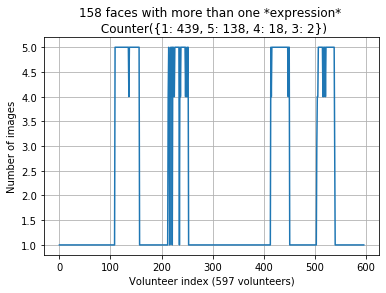

In [7]:
import collections

n_images_user=[]
list_all_images=[]
path_all_images=[]

for i in range(df_targets.shape[0]): # For loop through all the images:
    dir_user=data_dir+df_targets.Target.values[i]+'/'
    list_user_images=os.listdir(dir_user)
    if('.DS_Store' in list_user_images):
        list_user_images.remove('.DS_Store')
    list_all_images.extend(list_user_images)
    path_all_images.extend([dir_user+im for im in list_user_images])

    n_images_user.append(len(list_user_images))
plt.plot(n_images_user)
plt.title(f'{(np.array(n_images_user)>1).sum()} faces with more than one *expression* \n {collections.Counter(n_images_user)}');
plt.ylabel('Number of images')
plt.xlabel('Volunteer index (597 volunteers)')
plt.grid('On')

In [8]:
def impath_extract(im):
    """
    
    Helper function to extract all the properties of the image from the file-name
    
    """
    list_name=im.split('/')[-1].split('-')[1:3]
    race_im=list_name[0][0]
    gender_im=list_name[0][1]
    target_im=f'{list_name[0]}-{list_name[1]}'
    r_g_im=list_name[0]
    exprn_im=im.split('/')[-1].split('-')[-1].split('.')[0]
    return np.array([target_im,race_im,gender_im,r_g_im,exprn_im])

def preprocess(img):
    """
    
    Helper function to pre-process images into the ML-images model
    
    """
    rawH = float(img.shape[0])
    rawW = float(img.shape[1])
    newH = 256.0
    newW = 256.0
    test_crop = 224.0 

    if rawH <= rawW:
        newW = (rawW/rawH) * newH
    else:
        newH = (rawH/rawW) * newW
    img = cv.resize(img, (int(newW), int(newH)))
    img = img[int((newH-test_crop)/2):int((newH-test_crop)/2)+int(test_crop),int((newW-test_crop)/2):int((newW-test_crop)/2)+int(test_crop)]
    img = ((img/255.0) - 0.5) * 2.0
    img = img[...,::-1]
    return img

For loop through all the images:

```
col_list=['Target','race','gender','race_gender','exprn']
df_cfd=pd.DataFrame(columns=col_list)
N_images=len(path_all_images)
####
cfd_raw=np.zeros((N_images,1718, 2444, 3))
cfd_pre_proc=np.zeros((N_images,224,224, 3))
###
nonstandard_shape_list=[]
# This for-looping over the dataset will ensure that there's 
# one-to-one mapping between images & the dataframe entries
for i,im in tqdm(enumerate(path_all_images)):
    raw_img = cv.imread(im)
    try:
        cfd_raw[i]=raw_img
    except:
        print(raw_img.shape)
        nonstandard_shape_list.append(raw_img.shape)
        cfd_raw[i]=cv.resize(raw_img, (2444,1718))
    cfd_pre_proc[i]=preprocess(raw_img)
    df_cfd.loc[i,:]=impath_extract(im) 
```

Having generated the tensors in Notebook-2, we proceed to load the numpy tensors:

In [9]:
# Load the 
cfd_pre_proc=np.load('cfd_pre_proc.npy')
df_cfd=pd.read_csv('df_cfd_images.csv')

cfd_pre_proc.shape,df_cfd.shape

((1207, 224, 224, 3), (1207, 5))

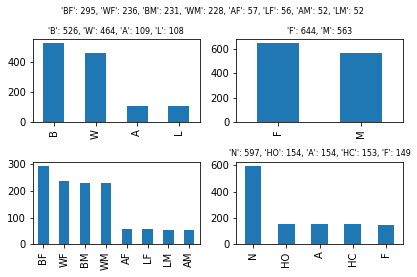

In [10]:
plt.plot(figsize=(15,6))
plt.subplot(221)
df_cfd.race.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.race)).split('{')[1].split('}')[0],fontsize=8);

plt.subplot(222)
df_cfd.gender.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.gender)).split('{')[1].split('}')[0],fontsize=8);


plt.subplot(223)
df_cfd.race_gender.value_counts().plot(kind='bar')
# plt.title(str(collections.Counter(df_cfd.race_gender)).split('{')[1].split('}')[0],fontsize=8);

plt.subplot(224)
df_cfd.exprn.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.exprn)).split('{')[1].split('}')[0],fontsize=8);
plt.suptitle(str(collections.Counter(df_cfd.race_gender)).split('{')[1].split('}')[0],fontsize=8);
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

AF 57
AM 52
BF 295
BM 231
LF 56
LM 52
WF 236
WM 228


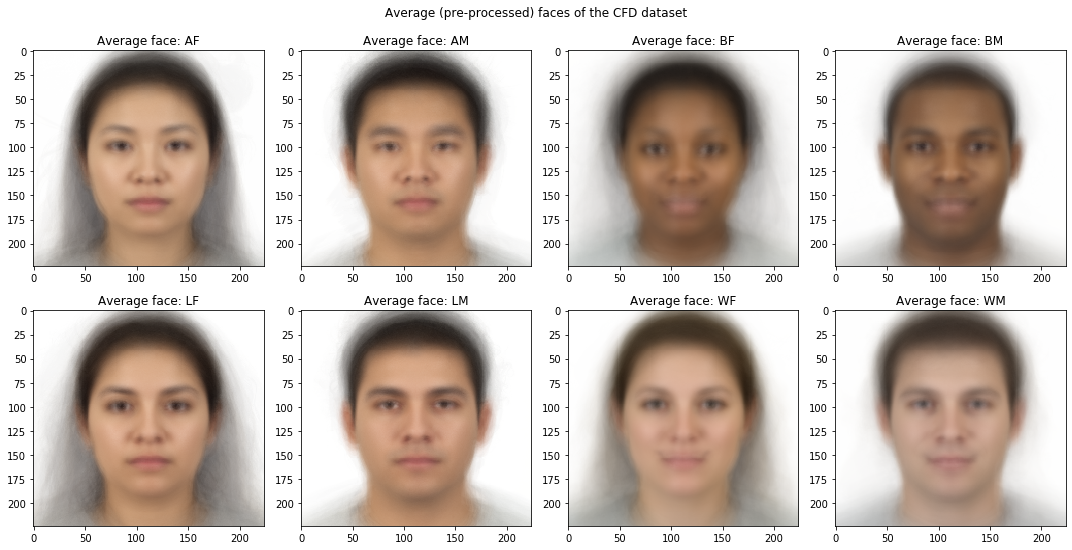

In [11]:
import warnings
warnings.filterwarnings('ignore')
r_g_list=df_cfd.race_gender.unique()
ind_sp=1
plt.figure(figsize=(15,8))
avg_images_array=np.zeros((8,224,224,3))
for r_g in r_g_list:
    ind_rg=np.where(df_cfd.loc[:,'race_gender']==r_g)[0]
    print(r_g,len(ind_rg))
    avg_img=np.zeros((224, 224, 3))
    for ind in ind_rg:
        avg_img+=cfd_pre_proc[ind]
    avg_img=avg_img/len(ind_rg)
    plt.subplot(2,4,ind_sp)
    avg_images_array[ind_sp-1]=avg_img
    plt.imshow((avg_img+1)/2,aspect='auto');
    # plt.axis('Off')
    
    ind_sp+=1
    plt.title(f'Average face: {r_g}')
plt.suptitle('Average (pre-processed) faces of the CFD dataset')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# save_figure('mean_faces',plt)
plt.savefig('./plots/mean_faces.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.savefig('./plots/mean_faces.png',dpi=300,bbox_inches = 'tight', pad_inches = 0)

# Section -1b : Model inference with mean images.
Load the model weights, get the dictionary (for the labels) and the unsafe synset data-frame:

In [12]:
################################################################################
images = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])
net = resnet.ResNet(images, is_training=False)
net.build_model()

logit = net.logit
prob = tf.nn.softmax(logit)
prob_topk, pred_topk = tf.nn.top_k(prob, k=20)

# restore model
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement=False
sess = tf.Session(config=config)
saver = tf.train.Saver(tf.global_variables())
saver.restore(sess, "./checkpoints/model.ckpt")
print('Architecture details \n')
print(f'N_class:{net.num_classes},Stages: {net.stages}, N_filters: {net.filters}')
#####################################################################################
url_ml='https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt'
df_ml=pd.read_csv(url_ml,delimiter='	')
print(df_ml.shape)
df_ml.head()
dictionary_ml = {}
N_class=df_ml.shape[0]
keys = range(N_class)
values = list(df_ml.loc[:,'category name'].values)
from tqdm.notebook import tqdm
for i in keys:
        dictionary_ml[i] = values[i]
        
#######################################################################################
url_unsafe_synsets_imagenet='http://image-net.org/filtering-and-balancing/unsafe_synsets.txt'
url_ml='https://raw.githubusercontent.com/Tencent/tencent-ml-images/master/data/dictionary_and_semantic_hierarchy.txt'
# 1: Read the Unsafe classes from the ImageNet portal
df=pd.read_csv(url_unsafe_synsets_imagenet,header=None)
print(df.shape)
synsets_unsafe=df[0].values

################################
df_ml['unsafe_synset']=df_ml.category_id.isin(synsets_unsafe)
df_ml_unsafe=df_ml.loc[df_ml.category_id.isin(synsets_unsafe)]
df_ml_unsafe.reset_index(inplace=True,drop=True)
df_ml_unsafe.shape


Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt
Architecture details 

N_class:11166,Stages: [3, 4, 23, 3], N_filters: [256, 512, 1024, 2048]
(11166, 4)
(1593, 1)


(315, 5)

In [13]:
df_ml_unsafe.index_of_parent_category.nunique()

111

Two different ways of measuring response to mean-faces:

1. Feed  in the mean image of the pre-processed images
2. Read the raw images, find their mean and then infer with pre-processed mean-image

Procedure-1: Feed  in the mean image of the pre-processed images to the model

(8, 11166) (8, 20) (8, 20)


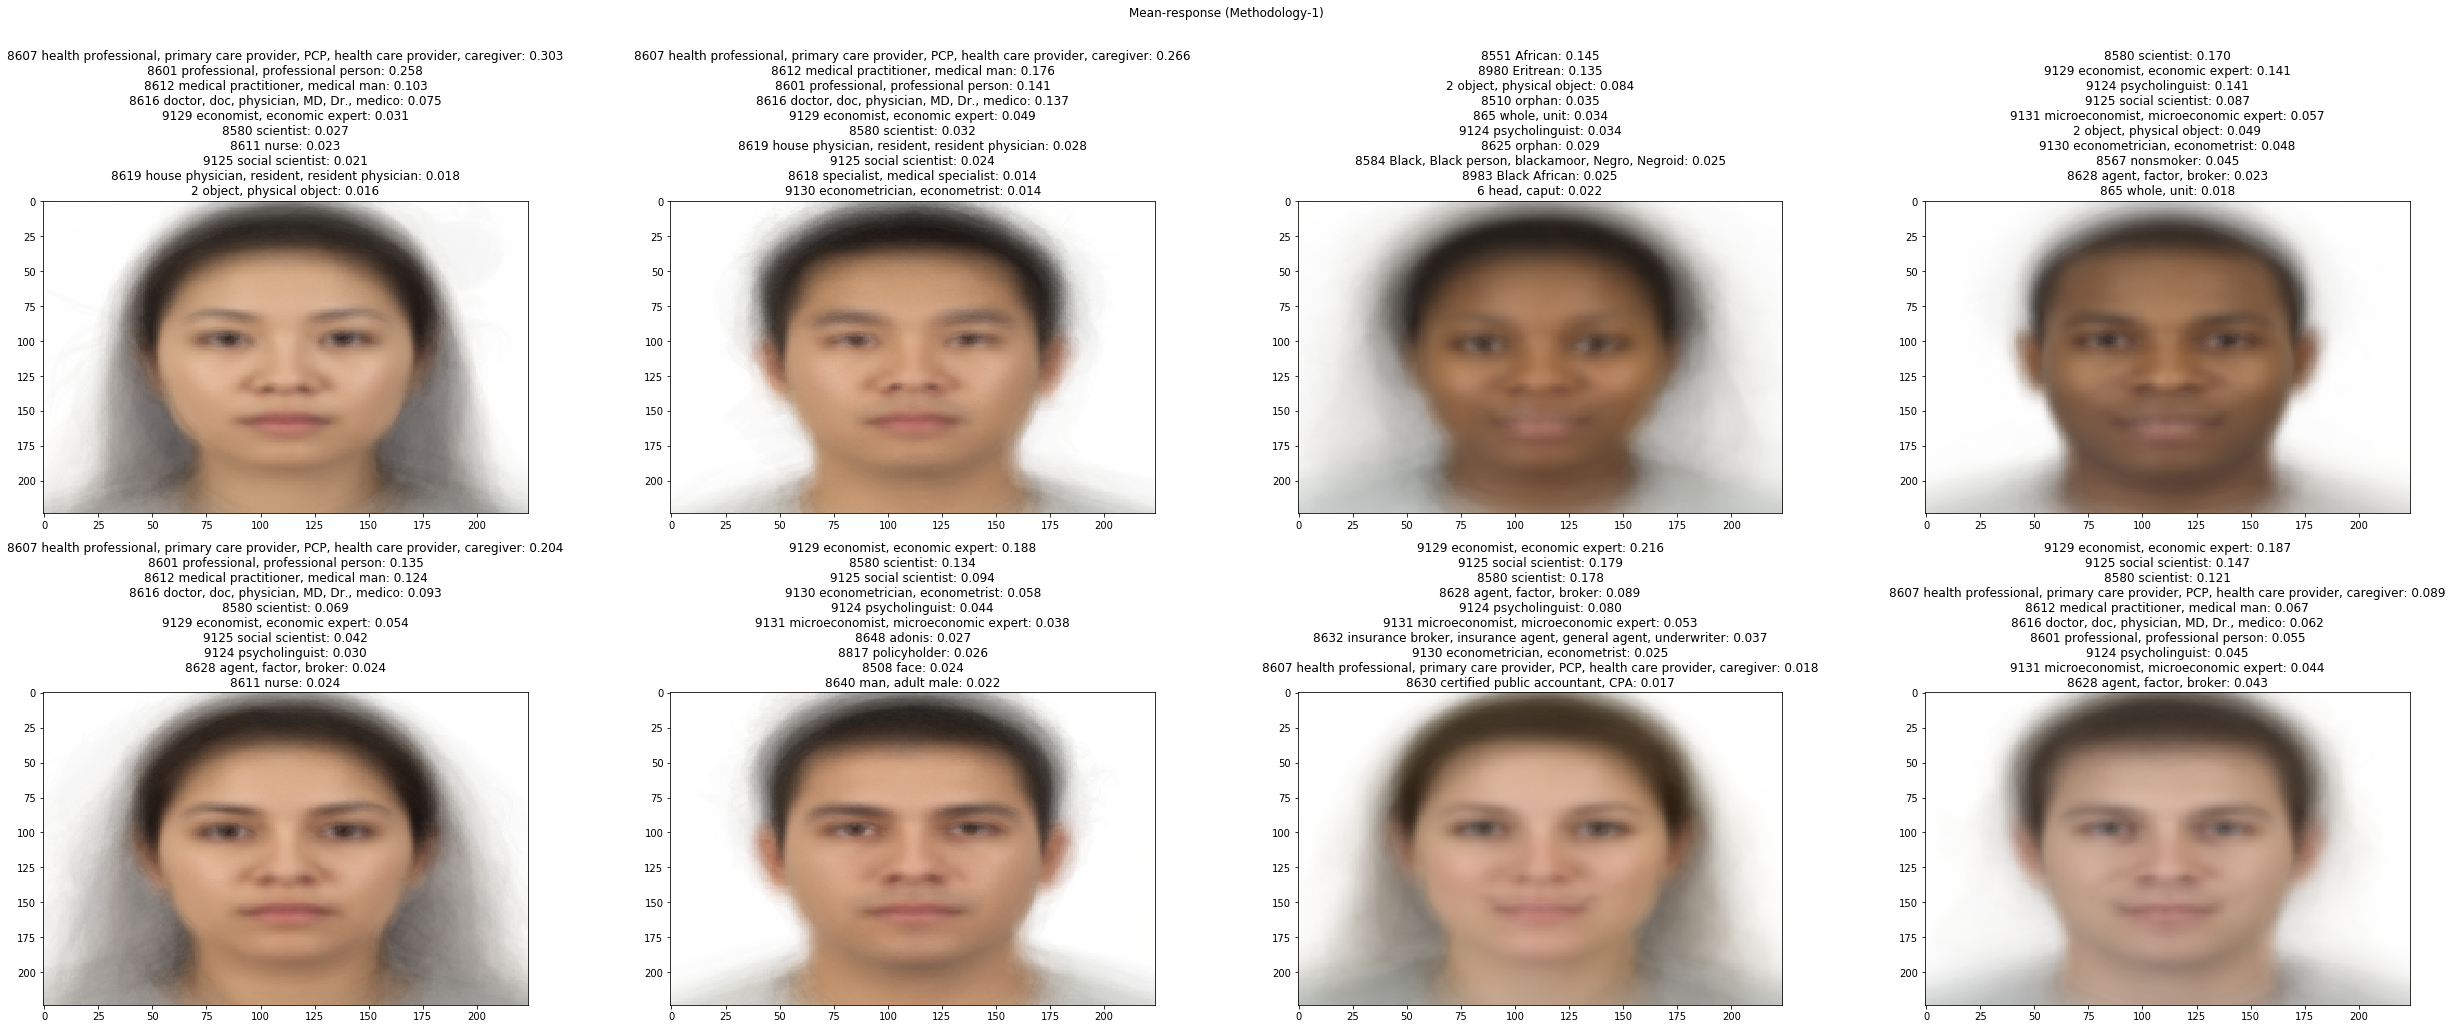

In [14]:
logits, probs_topk, preds_topk = sess.run([logit, prob_topk, pred_topk], {images:avg_images_array})
print(logits.shape,probs_topk.shape,preds_topk.shape)
preds_topk = np.squeeze(preds_topk)
#########################################
K_top=10
plt.figure(figsize=(35,15))
          
for ind in range(8):
    preds_topk_i=preds_topk[ind]
    probs_topk_i=probs_topk[ind]
    names_topk_i = [dictionary_ml[i] for i in preds_topk_i]

    plt.subplot(2,4,ind+1)
    plt.imshow((avg_images_array[ind]+1)/2,aspect='auto');
    predictions = []
    for ii, pred in enumerate(preds_topk_i[0:K_top]):
        predictions.append('%d %s: %.3f' % (pred, names_topk_i[ii], probs_topk_i[ii]))
    plt.title('\n'.join(predictions))

    
plt.suptitle('Mean-response (Methodology-1)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/mean_responses_1.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.savefig('./plots/mean_responses_1.png',dpi=300,bbox_inches = 'tight', pad_inches = 0)

Procedure-2: Read the raw images, find their mean and then infer with pre-processed mean-image

AF 57
AM 52
BF 295
BM 231
LF 56
LM 52
WF 236
WM 228


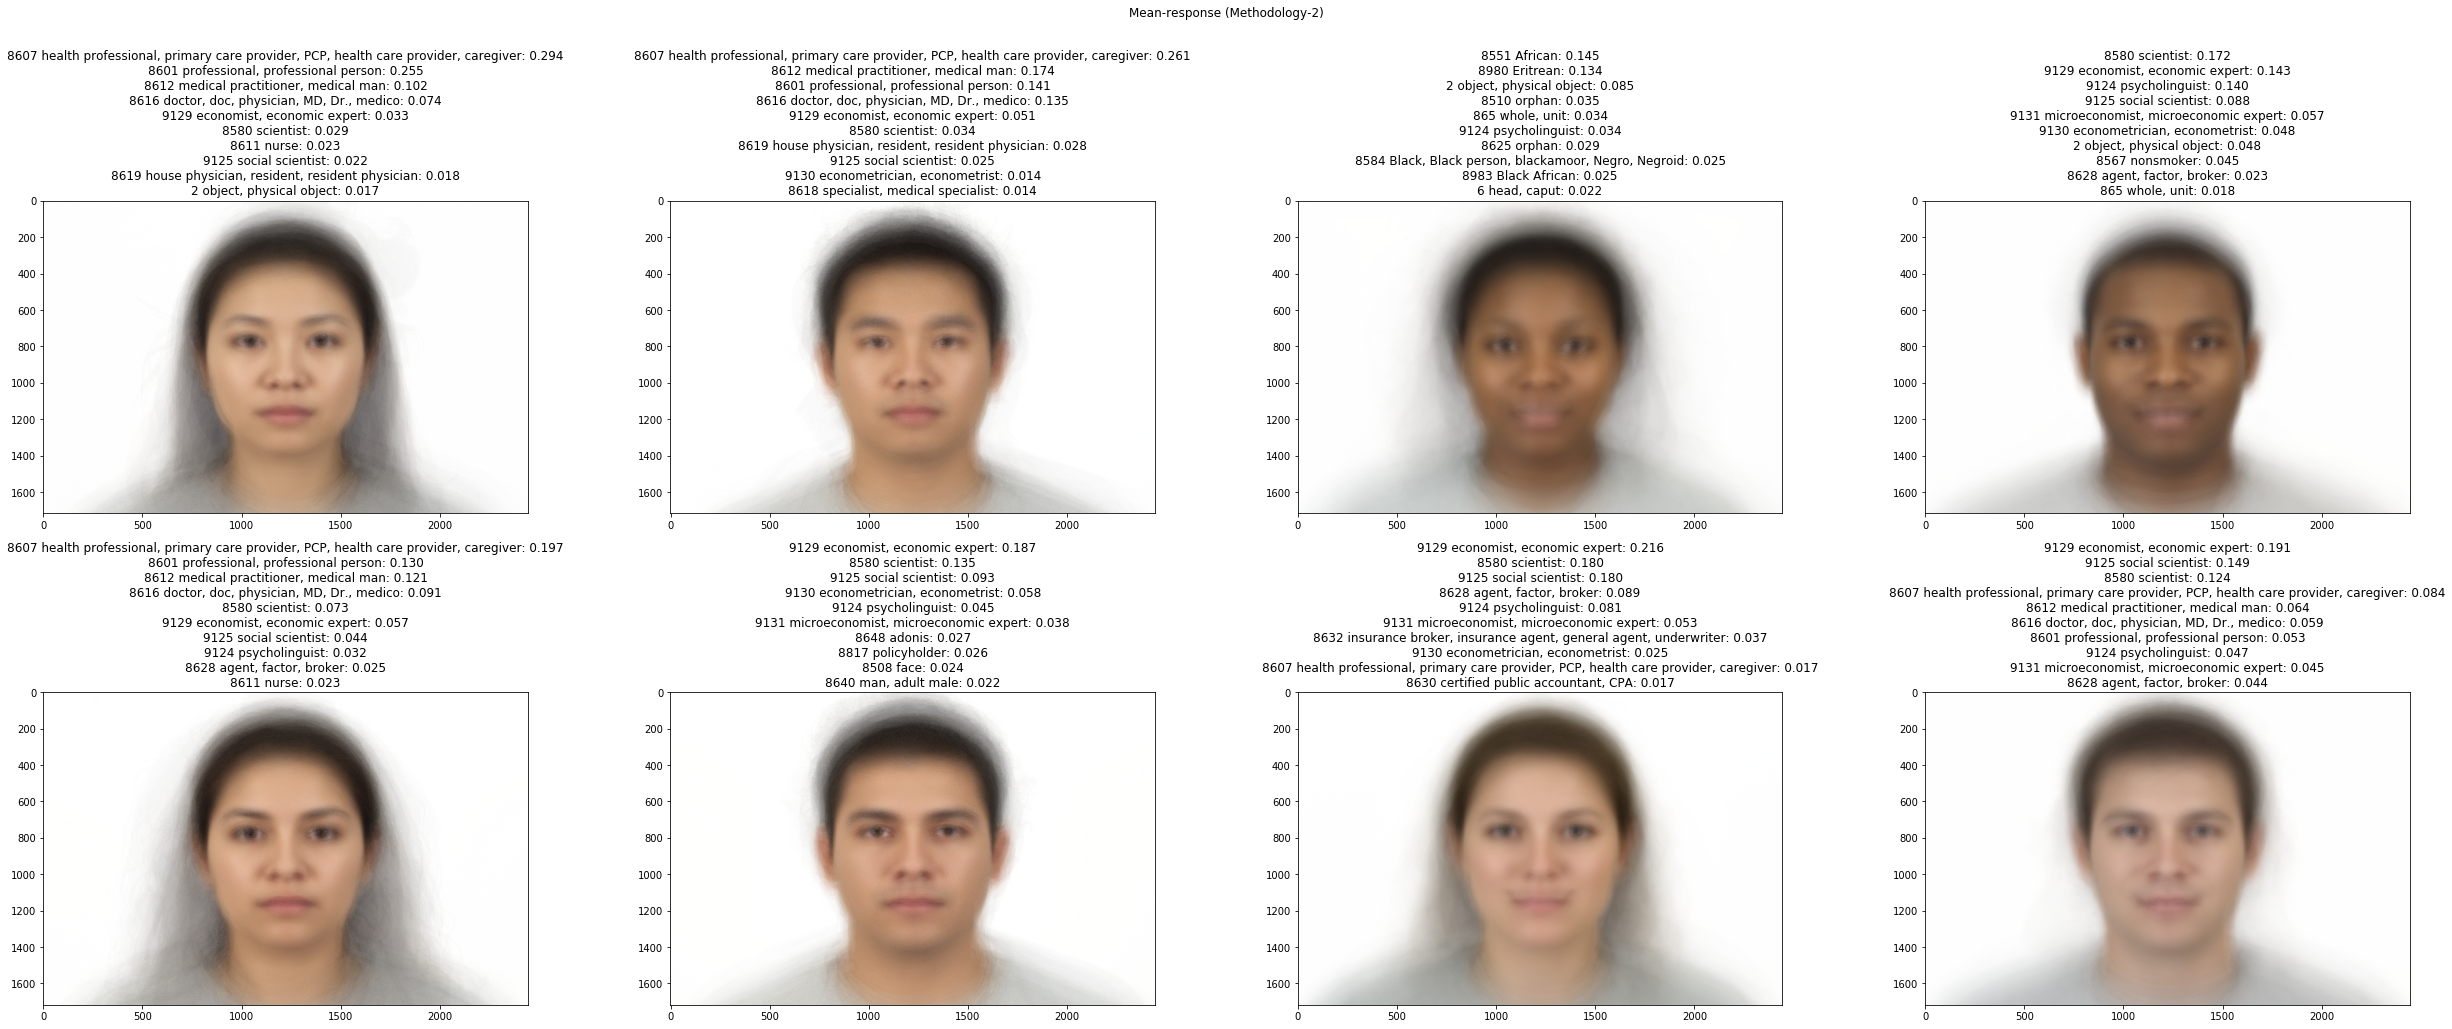

In [15]:
r_g_list=df_cfd.race_gender.unique()
ind_sp=1
plt.figure(figsize=(35,15))
avg_images_array=np.zeros((8,224,224,3))
K_top=10
for r_g in r_g_list:
    ind_rg=np.where(df_cfd.loc[:,'race_gender']==r_g)[0]
    print(r_g,len(ind_rg))
    avg_img=np.zeros((224, 224, 3))
    raw_img_rg_list=[]
    ########################
    for ind in ind_rg:
        raw_img_rg = cv.imread(path_all_images[ind])
        raw_img_rg_list.append(cv.resize(raw_img_rg, (2444,1718)))
    #########################
    avg_img=np.mean(np.array(raw_img_rg_list),axis=0)
    avg_img_preproc=preprocess(avg_img)
    logits, probs_topk, preds_topk = sess.run([logit, prob_topk, pred_topk], {images:np.expand_dims(avg_img_preproc, axis=0)})
    preds_topk = np.squeeze(preds_topk)
    names_topk = [dictionary_ml[i] for i in preds_topk]
    plt.subplot(2,4,ind_sp)
    plt.imshow(avg_img.astype(int)[...,::-1],aspect='auto');
    predictions = []
    for ii, pred in enumerate(preds_topk[0:K_top]):
        predictions.append('%d %s: %.3f' % (pred, names_topk[ii], probs_topk[0][ii]))

    plt.title('\n'.join(predictions))
    
    ind_sp+=1
    
plt.suptitle('Mean-response (Methodology-2)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/mean_responses_2.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.savefig('./plots/mean_responses_2.png',dpi=300,bbox_inches = 'tight', pad_inches = 0)

In [16]:
df_ml.head()

category_index category_id  index_of_parent_category  \
0               0   n00002452                        -1   
1               1   n00020827                        -1   
2               2   n00002684                        -1   
3               3   n11425580                        -1   
4               4   n05220461                         0   

             category name  unsafe_synset  
0                    thing          False  
1                   matter          False  
2  object, physical object          False  
3   atmospheric phenomenon          False  
4                body part          False

# Section-2: Inference over the entire dataset:

In [17]:
import time
t_0=time.time()
logits_cfd,probs_top20_cfd, preds_top20_cfd = sess.run([logit, prob_topk, pred_topk], {images:cfd_pre_proc})
print(time.time()-t_0)

100.18203330039978


In [18]:
np.save('logits_1207x11166_cfd).npy',logits_cfd)
np.save('probs_top20_1207x20_cfd.npy',probs_top20_cfd)
np.save('class_top20_1207x20_cfd.npy',preds_top20_cfd)

In [19]:
logits_cfd.shape,preds_top20_cfd.shape,probs_top20_cfd.shape

((1207, 11166), (1207, 20), (1207, 20))

Post-run verifications:


1- Make sure that the hand evaluted and sorted softmax values from the logits are the same as the ones from preds_top20_cfd and probs_top20_cfd

In [20]:
from scipy.special import softmax 
RANDOM_IMG=27
x=softmax(logits_cfd[RANDOM_IMG,:])
x[np.argsort(-x)[0:20]],probs_top20_cfd[RANDOM_IMG],np.argsort(-x)[0:20],preds_top20_cfd[RANDOM_IMG,:].astype(int)

(array([0.08701143, 0.06706317, 0.04932059, 0.04443395, 0.03748216,
        0.02718069, 0.02191724, 0.02150569, 0.02058625, 0.02017793,
        0.01598933, 0.01554546, 0.01476314, 0.01466553, 0.01291048,
        0.01266418, 0.01257079, 0.01231746, 0.01229736, 0.01142408],
       dtype=float32),
 array([0.0870114 , 0.06706314, 0.04932057, 0.04443394, 0.03748215,
        0.02718068, 0.02191723, 0.02150569, 0.02058624, 0.02017792,
        0.01598932, 0.01554545, 0.01476314, 0.01466552, 0.01291047,
        0.01266417, 0.01257079, 0.01231746, 0.01229735, 0.01142407],
       dtype=float32),
 array([ 8472,  5175,  4664,     2,   865,  8508, 10872,  9142,  8607,
         8474, 10392,  4658,  8971,  9298,  8612,  9129,  1871, 11094,
         8580, 10966]),
 array([ 8472,  5175,  4664,     2,   865,  8508, 10872,  9142,  8607,
         8474, 10392,  4658,  8971,  9298,  8612,  9129,  1871, 11094,
         8580, 10966]))

2- Visual inspection:

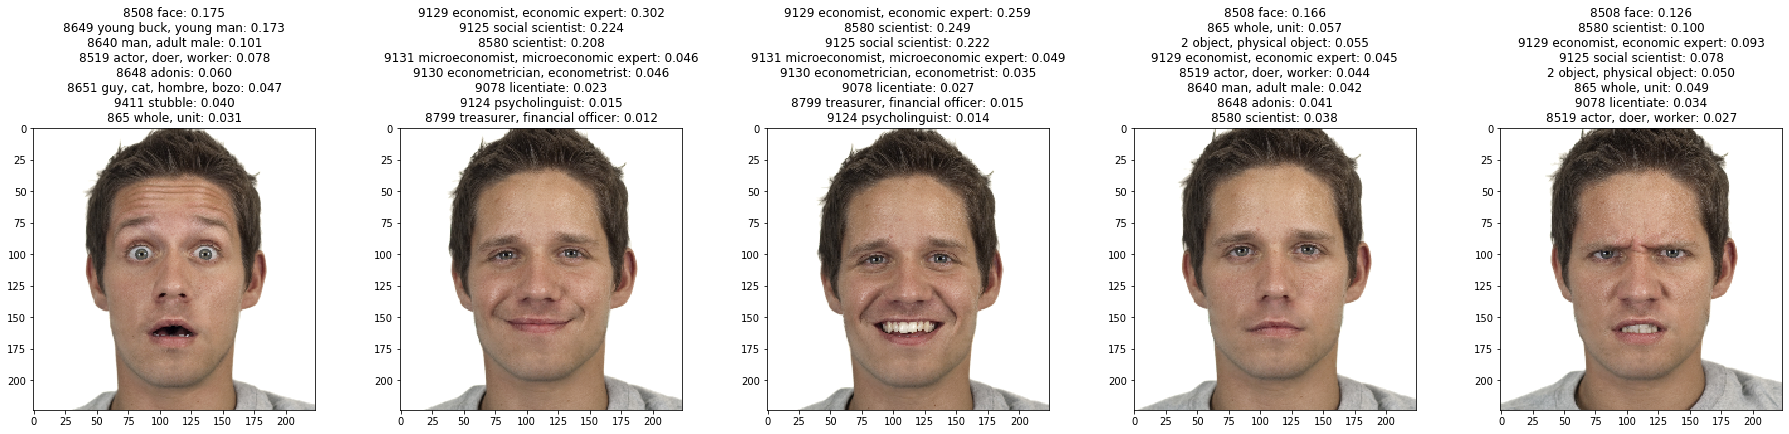

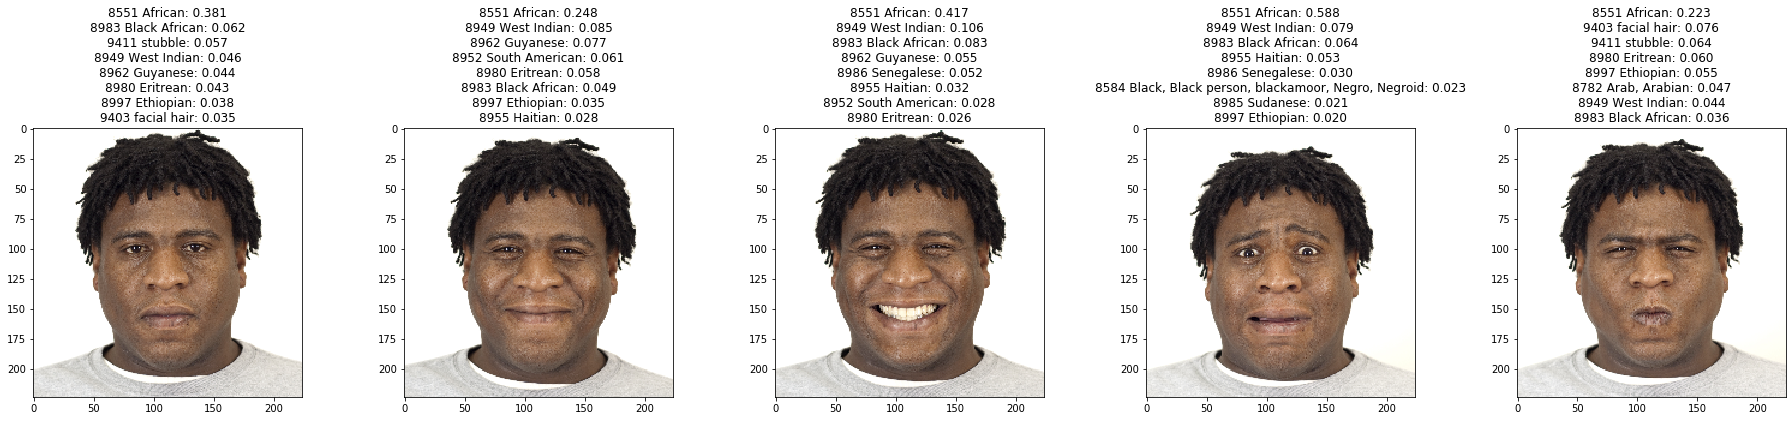

In [21]:
# Manual selection 
test_dir=os.getcwd()+'/data/images/cfd/CFD Version 2.0.3/CFD 2.0.3 Images/WM-004/'
fig=plt.figure(figsize=(25,10))

for im_ind,im in enumerate(os.listdir(test_dir)):
    im=test_dir+im
    raw_img = cv.imread(im)
    img = preprocess(raw_img)
    logits, probs_topk, preds_topk = sess.run([logit, prob_topk, pred_topk], {images:np.expand_dims(img, axis=0)})
    preds_topk = np.squeeze(preds_topk)
#     print(preds_topk)
    names_topk = [dictionary_ml[i] for i in preds_topk]
    ax = fig.add_subplot(1, 5,im_ind+ 1)
    ax.imshow((img+1)/2)
    predictions = []
    for i, pred in enumerate(preds_topk[0:8]):
        predictions.append('%d %s: %.3f' % (pred, names_topk[i], probs_topk[0][i]))
        
    ax.set_title('\n'.join(predictions))
plt.tight_layout()    

test_dir=os.getcwd()+'/data/images/cfd/CFD Version 2.0.3/CFD 2.0.3 Images/BM-038/'
fig=plt.figure(figsize=(25,10))

for im_ind,im in enumerate(os.listdir(test_dir)):
    im=test_dir+im
    raw_img = cv.imread(im)
    img = preprocess(raw_img)
    logits, probs_topk, preds_topk = sess.run([logit, prob_topk, pred_topk], {images:np.expand_dims(img, axis=0)})
    preds_topk = np.squeeze(preds_topk)
#     print(preds_topk)
    names_topk = [dictionary_ml[i] for i in preds_topk]
    ax = fig.add_subplot(1, 5,im_ind+ 1)
    ax.imshow((img+1)/2)
    predictions = []
    for i, pred in enumerate(preds_topk[0:8]):
        predictions.append('%d %s: %.3f' % (pred, names_topk[i], probs_topk[0][i]))
        
    ax.set_title('\n'.join(predictions))
plt.tight_layout() 

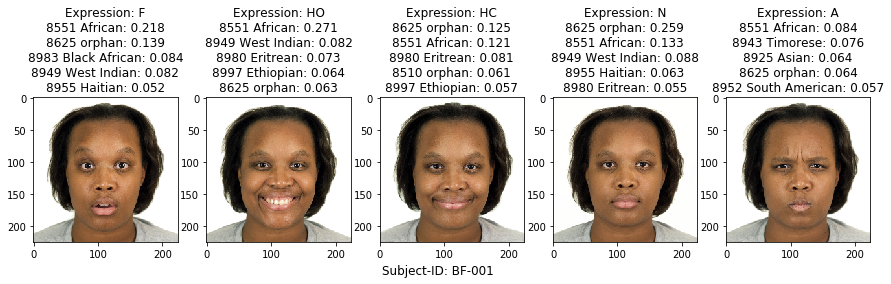

In [22]:
# Let us function-ize this plotting code. Will come in handy later while doing outlier analysis
def fetch_results(IM_ID,df_cfd,K_top=5):
    """
    Here's a helper function that takes in an Image-ID and spits out the K_top results 
    without having to re-run inference or re-processing the image
    """
    ind_search=np.where(df_cfd.Target.values==IM_ID)[0]
    if(len(ind_search)==0):
        print('No such image!')
        return None
    plt.figure(figsize=(15,4))
    PRED_ALL=[]
    for ii, ind_ in enumerate(ind_search):

        plt.subplot(1,5,ii+1)
        plt.imshow((cfd_pre_proc[ind_] +1)/2)       

        pred_topk=preds_top20_cfd[ind_].astype(int)
        names_topk = [dictionary_ml[i].split(',')[0] for i in pred_topk]
        probs_topk=probs_top20_cfd[ind_]

        predictions = []
        for i, pred in enumerate(pred_topk[0:K_top]):
            predictions.append('%d %s: %.3f' % (pred, names_topk[i], probs_topk[i]))

        plt.title('Expression: '+df_cfd.loc[ind_,'exprn']+'\n'+'\n'.join(predictions))
        PRED_ALL.append(predictions)

    plt.suptitle(f'Subject-ID: {IM_ID}',y=.175)
#     plt.tight_layout(rect=[1.2, 0.3,1, 0.95])
    return PRED_ALL
# Example:
_=fetch_results('BF-001',df_cfd,K_top=5)

Now, let's perform some top-1 analysis on the images.

In [23]:
df_cfd['top_class']=[dictionary_ml[i] for i in preds_top20_cfd[:,0].astype(int)]
df_cfd['top_class_ind']=preds_top20_cfd[:,0].astype(int)
df_cfd['top_class_softmax']=probs_top20_cfd[:,0]
df_cfd['top_class_parent']=df_ml.loc[df_cfd.top_class_ind.values,'index_of_parent_category'].values
df_cfd['top_class_unsafe']=df_ml.loc[df_cfd.top_class_ind.values,'unsafe_synset'].values
df_cfd.head()

Target race gender race_gender exprn  \
0  AF-200    A      F          AF     N   
1  AF-201    A      F          AF     N   
2  AF-202    A      F          AF     N   
3  AF-203    A      F          AF     N   
4  AF-204    A      F          AF     N   

                                           top_class  top_class_ind  \
0  health professional, primary care provider, PC...           8607   
1    spot, speckle, dapple, patch, fleck, maculation           4658   
2                                               face           8508   
3                         makeup, make-up, war paint           1871   
4                                           Filipino           8499   

   top_class_softmax  top_class_parent  top_class_unsafe  
0           0.062420              8601             False  
1           0.090574              4649             False  
2           0.118440              5177             False  
3           0.411337              1850             False  
4           0.117466              5177              True

In [24]:
df_cfd.top_class_unsafe.value_counts()

False    1090
True      117
Name: top_class_unsafe, dtype: int64

For the rest of the analysis, let's write up two helper functions to update the neutral sub-df and saving the images/plots generated

In [25]:
def update_neutral(df_cfd):
    """
    Helper function to update the neutral sub-df everytime 
    I update df_cfd
    """
    df_cfd_neutral=df_cfd.loc[df_cfd.exprn=='N']
    df_cfd_neutral.reset_index(inplace=True,drop=True)
    print(df_cfd_neutral.shape)
    return df_cfd_neutral
df_cfd_neutral=update_neutral(df_cfd)
def save_figure(file_name,plt):
    """
    Helper function to save images
    """
    plt.savefig(f'./plots/{file_name}.pdf',bbox_inches = 'tight', pad_inches = 0)  
    plt.savefig(f'./plots/{file_name}.png',dpi=300,bbox_inches = 'tight', pad_inches = 0) 

(597, 10)


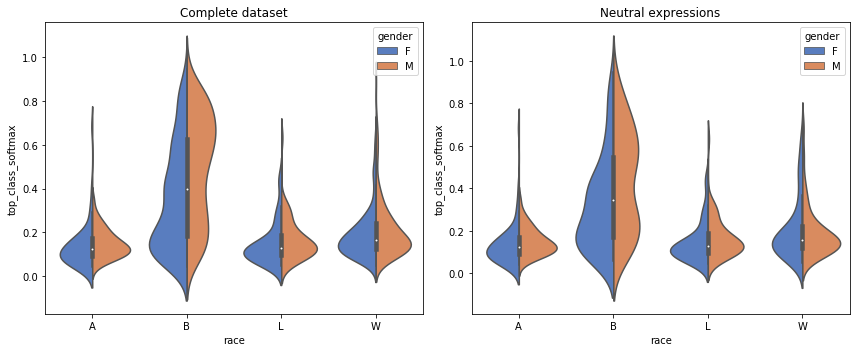

In [26]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
ax = sns.violinplot(x="race", y="top_class_softmax", hue="gender",data=df_cfd, palette="muted",split=True)
plt.title('Complete dataset')
plt.subplot(122)
ax = sns.violinplot(x="race", y="top_class_softmax", hue="gender",data=df_cfd_neutral, palette="muted",split=True)
plt.title('Neutral expressions')
plt.tight_layout()
save_figure('violin_race_gender',plt)

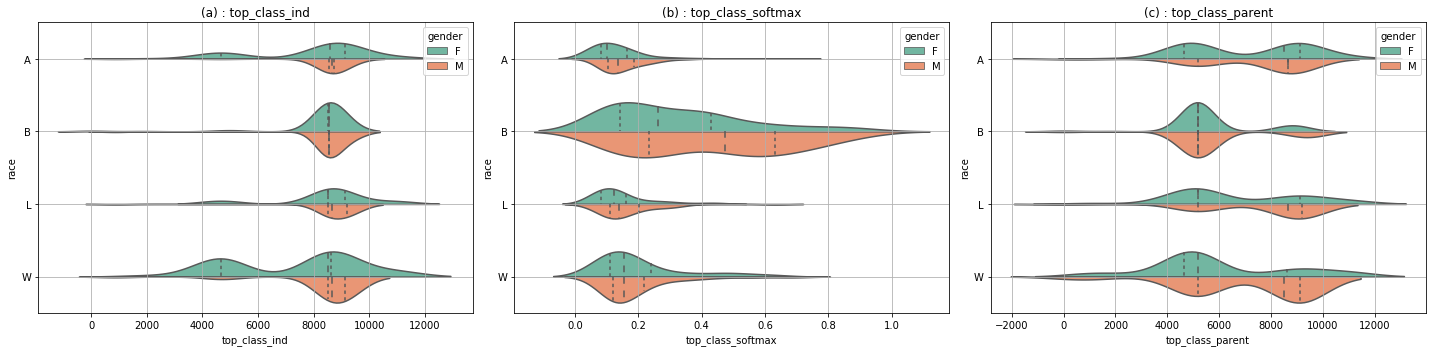

In [27]:
par_vec=['top_class_ind', 'top_class_softmax', 'top_class_parent']
import string
alphabet_vec=string.ascii_lowercase[:len(par_vec)]

plt.figure(figsize=(20,5))
for i in range(len(par_vec)):
    plt.subplot(1,3,i+1)
    try:
        sns.violinplot(y="race", x=par_vec[i], hue="gender",
                    data=df_cfd_neutral, palette="Set2", split=True,
                    scale="count", inner="quartile", scale_hue=False)

        plt.title(f'({(alphabet_vec[i])}) : {par_vec[i]}')
        plt.grid('On')

    except:
        plt.title(par_vec[i])
        pass
plt.tight_layout()
save_figure('top1_analysis_neutral',plt)

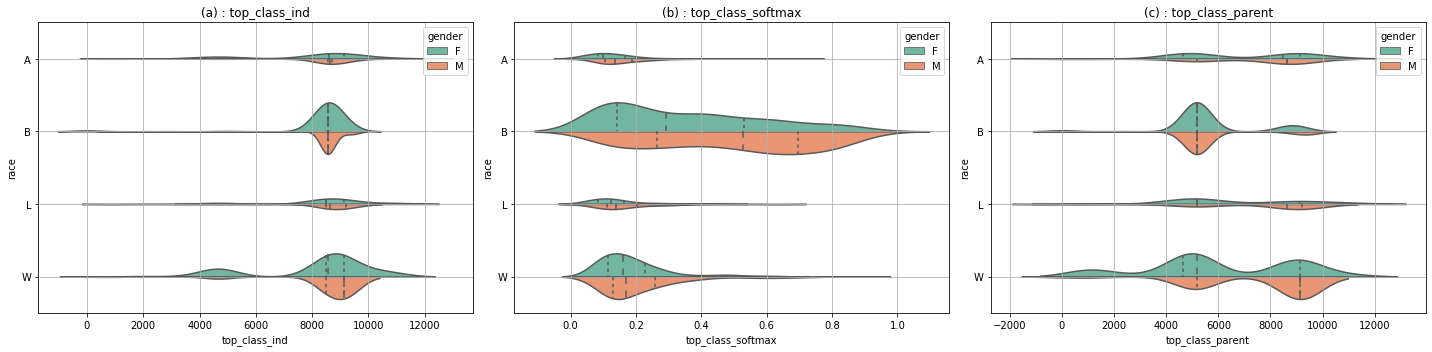

In [28]:
par_vec=['top_class_ind', 'top_class_softmax', 'top_class_parent']
alphabet_vec=string.ascii_lowercase[:len(par_vec)]

plt.figure(figsize=(20,5))
for i in range(len(par_vec)):
    plt.subplot(1,3,i+1)
    try:
        sns.violinplot(y="race", x=par_vec[i], hue="gender",
                    data=df_cfd, palette="Set2", split=True,
                    scale="count", inner="quartile", scale_hue=False)

        plt.title(f'({(alphabet_vec[i])}) : {par_vec[i]}')
        plt.grid('On')

    except:
        plt.title(par_vec[i])
        pass
plt.tight_layout()
save_figure('top1_analysis_all',plt)

In [29]:
df_cfd['top_class_comb']=df_cfd.top_class_ind.astype(str)+'-'+df_cfd.top_class.astype(str)
df_cfd['top_class_comb_2']=df_cfd.top_class_parent.astype(str)+'-'+df_cfd.top_class.astype(str)

df_cfd_neutral=df_cfd.loc[df_cfd.exprn=='N']
df_cfd_neutral.reset_index(inplace=True,drop=True)
print(df_cfd_neutral.shape)
df_cfd_neutral.head(2)

(597, 12)


Target race gender race_gender exprn  \
0  AF-200    A      F          AF     N   
1  AF-201    A      F          AF     N   

                                           top_class  top_class_ind  \
0  health professional, primary care provider, PC...           8607   
1    spot, speckle, dapple, patch, fleck, maculation           4658   

   top_class_softmax  top_class_parent  top_class_unsafe  \
0           0.062420              8601             False   
1           0.090574              4649             False   

                                      top_class_comb  \
0  8607-health professional, primary care provide...   
1  4658-spot, speckle, dapple, patch, fleck, macu...   

                                    top_class_comb_2  
0  8601-health professional, primary care provide...  
1  4649-spot, speckle, dapple, patch, fleck, macu...

 Cross-tab evaluations:

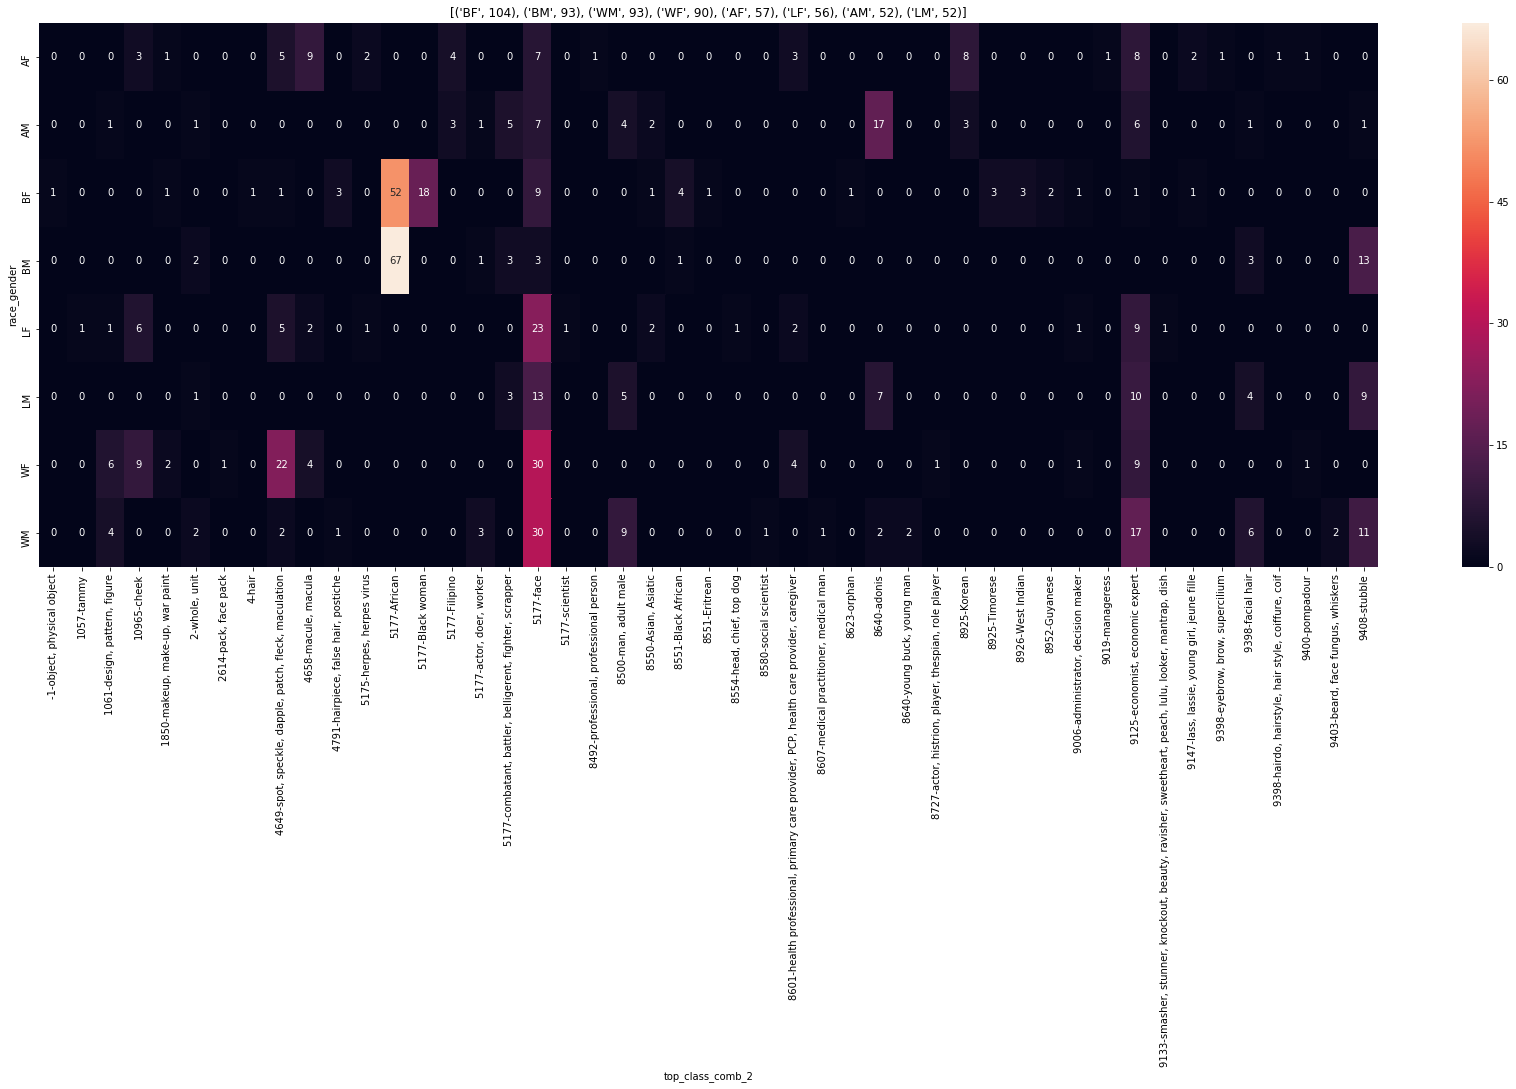

In [30]:
CT_rg1=pd.crosstab(df_cfd_neutral.race_gender,df_cfd_neutral.top_class_comb_2)
CT_rg1.to_csv('CT_rg_neutral.csv')
########################################################
CT_rg1_norm=pd.crosstab(df_cfd_neutral.race_gender,df_cfd_neutral.top_class_comb_2,normalize='index')
CT_rg1_norm.to_csv('CT_rg_neutral_norm.csv')
#########################################################
import seaborn as sns
plt.figure(figsize = (30,10))
ax = sns.heatmap(CT_rg1, annot=True, fmt="d")
vc=df_cfd_neutral.race_gender.value_counts()
plt.title(list(zip(vc.index.values,vc.values)))
save_figure('CT_rg_top1',plt)

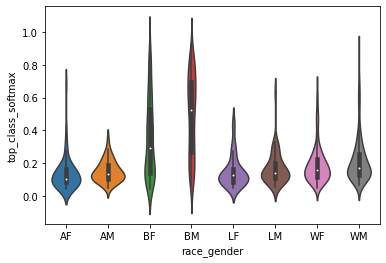

In [31]:
ax = sns.violinplot(x="race_gender", y="top_class_softmax", data=df_cfd)

# Top-k analysis:

In [32]:
mask_neutral=df_cfd.exprn=='N'
mask_neutral.sum()

597

Q1: How many classes are in the super-set of the top5 labels?

0 0
1 56
2 80
3 98
4 119
5 129
6 144
7 152
8 162
9 168
10 177
0 0
1 47
2 65
3 84
4 103
5 115
6 129
7 138
8 147
9 153
10 164


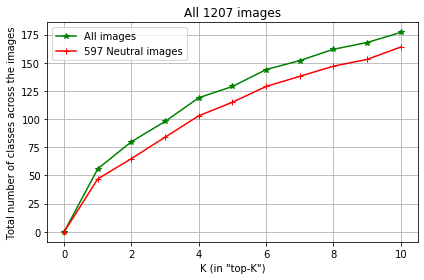

In [33]:
K_TOP_MAX=11
n_class_k=np.zeros(K_TOP_MAX,dtype=int)

for k in range(K_TOP_MAX):
    class_mat=preds_top20_cfd[:,0:k].astype(int)
    classes_top5=np.unique(class_mat.flatten())
    classes_top5.sort()
    classes_top5_names=[dictionary_ml[classes_top5[i]] for i in range(len(classes_top5))]
    n_class_k[k]=len(classes_top5)
    print(k, n_class_k[k])
plt.figure()
plt.plot(np.arange(K_TOP_MAX),n_class_k,'-*g')
plt.xlabel('K (in "top-K")')
plt.ylabel('Total number of classes across the images')
plt.grid('On')
plt.title('All 1207 images')
##################################################
n_class_k=np.zeros(K_TOP_MAX,dtype=int)
for k in range(K_TOP_MAX):
    class_mat=preds_top20_cfd[df_cfd.exprn=='N',0:k].astype(int)
    classes_top5=np.unique(class_mat.flatten())
    classes_top5.sort()
    classes_top5_names=[dictionary_ml[classes_top5[i]] for i in range(len(classes_top5))]
    n_class_k[k]=len(classes_top5)
    print(k, n_class_k[k])
plt.plot(np.arange(K_TOP_MAX),n_class_k,'-+r')
plt.xlabel('K (in "top-K")')
plt.ylabel('Total number of classes across the images')
plt.grid('On')
plt.legend(['All images','597 Neutral images'])
plt.tight_layout()

So, for k=5, we have 115 classes.

In [34]:
class_mat=preds_top20_cfd[mask_neutral,0:5].astype(int)
classes_top5=np.unique(class_mat.flatten())
classes_top5.sort()
classes_top5_names=[dictionary_ml[classes_top5[i]] for i in range(len(classes_top5))]
print(len(classes_top5))

115


Neat. So, let us generate the CROSS-TAB MATRIX

In [35]:
CT_top5=pd.DataFrame(index=df_cfd_neutral.race_gender.unique(),columns=classes_top5)
for r_g in df_cfd_neutral.race_gender.unique():
    for c in classes_top5:
        ind_rg=np.where(df_cfd_neutral.race_gender==r_g)[0]
        CT_top5.loc[r_g,c]=(class_mat[ind_rg]==c).sum()
print(CT_top5.sum().sum()==(df_cfd_neutral.shape[0]*5))
#Check again:
print([dictionary_ml[i] for i in CT_top5.columns.values]==classes_top5_names)
CT_top5.columns=[dictionary_ml[i] for i in CT_top5.columns.values]
CT_top5

True
True


object, physical object  head, caput  hair  whole, unit  \
AF                       11            0     0            7   
AM                        9            0     0           20   
BF                       14            1     2           11   
BM                        8            0     0           11   
LF                       13            1     0            7   
LM                       10            0     0           20   
WF                       13            1     1            9   
WM                       22            0     2           29   

    living thing, animate thing  decoration, ornament, ornamentation  \
AF                            0                                    0   
AM                            1                                    0   
BF                            0                                    0   
BM                            0                                    0   
LF                            0                                    0   
LM                            0                                    0   
WF                            0                                    7   
WM                            0                                    1   

    cosmetic  makeup, make-up, war paint  eyeshadow  eyeliner  ...  \
AF         2                           2          1         1  ...   
AM         0                           0          0         0  ...   
BF         2                           2          0         0  ...   
BM         0                           0          0         0  ...   
LF         0                           2          0         0  ...   
LM         0                           0          0         0  ...   
WF         2                           2          1         0  ...   
WM         0                           0          0         0  ...   

    mustache, moustache  beard, face fungus, whiskers  stubble  \
AF                    0                             0        0   
AM                    0                             1       12   
BF                    0                             0        0   
BM                    1                             8       20   
LF                    0                             0        0   
LM                    1                            10       19   
WF                    0                             0        0   
WM                    3                            14       35   

    soul patch, Attilio  tammy  freckle, lentigo  feature, lineament  cheek  \
AF                    0      0                14                   4      6   
AM                    1      0                 0                   0      0   
BF                    0      0                 0                   0      0   
BM                    7      0                 0                   0      0   
LF                    0      2                10                   8     10   
LM                    5      0                 0                   0      0   
WF                    0      5                28                  17     19   
WM                   13      0                 3                   2      1   

    brow, forehead  eyebrow, brow, supercilium  
AF               0                           5  
AM               0                           0  
BF               0                           0  
BM               0                           0  
LF               2                           5  
LM               0                           0  
WF               2                           7  
WM               2                           0  

[8 rows x 115 columns]

 Prep for the categorization:

In [36]:
df_top5_cat=pd.DataFrame(columns=['class_name','class_cat'])
df_top5_cat['class_name']=list(CT_top5.columns)
df_top5_cat.to_csv('df_top5_cat.csv',index=False)
# Then hand-scribe it in G-Sheets and re-import the sheet
df_top5_cat=pd.read_csv('df_top5_class2cat.csv')
df_top5_cat.loc[df_top5_cat.class_cat=='body-part','class_cat']='physiology-related'
df_top5_cat.head(2)

class_name           class_cat
0  object, physical object           inanimate
1              head, caput  physiology-related

ethno-national        29
profession            27
facial-feature        17
fashion               10
persona-female         6
abstract               5
persona-male           5
inanimate              4
persona-slur           4
physiology-related     3
persona                3
clothing               2
Name: class_cat, dtype: int64


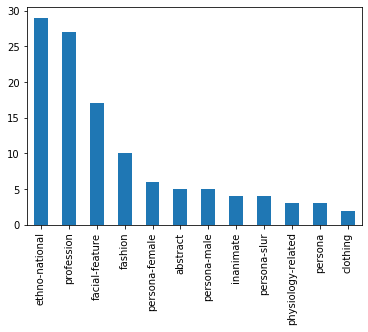

In [37]:
print(df_top5_cat.class_cat.value_counts())
df_top5_cat.class_cat.value_counts().plot(kind='bar')

Now, regenerate with the hand-annotated categories:

In [38]:
import pickle
# There is *NO* deep copy is pandas!
def deep_copy(df):
    return pickle.loads(pickle.dumps(df)) 

In [39]:
CT_top5_cat=deep_copy(CT_top5)
for i,c in enumerate(CT_top5_cat.columns):
#     print(CT_top5.columns[i])
    CT_top5_cat.columns.values[i]=df_top5_cat.loc[df_top5_cat.class_name==c,'class_cat'].values[0]
#     print(CT_top5.columns[i])
#     print('----')
CT_top5_cat

inanimate  physiology-related  physiology-related  abstract  abstract  \
AF         11                   0                   0         7         0   
AM          9                   0                   0        20         1   
BF         14                   1                   2        11         0   
BM          8                   0                   0        11         0   
LF         13                   1                   0         7         0   
LM         10                   0                   0        20         0   
WF         13                   1                   1         9         0   
WM         22                   0                   2        29         0   

    fashion  fashion  fashion  fashion  fashion  ...  facial-feature  \
AF        0        2        2        1        1  ...               0   
AM        0        0        0        0        0  ...               0   
BF        0        2        2        0        0  ...               0   
BM        0        0        0        0        0  ...               1   
LF        0        0        2        0        0  ...               0   
LM        0        0        0        0        0  ...               1   
WF        7        2        2        1        0  ...               0   
WM        1        0        0        0        0  ...               3   

    facial-feature  facial-feature  facial-feature  clothing  facial-feature  \
AF               0               0               0         0              14   
AM               1              12               1         0               0   
BF               0               0               0         0               0   
BM               8              20               7         0               0   
LF               0               0               0         2              10   
LM              10              19               5         0               0   
WF               0               0               0         5              28   
WM              14              35              13         0               3   

    facial-feature  facial-feature  facial-feature  facial-feature  
AF               4               6               0               5  
AM               0               0               0               0  
BF               0               0               0               0  
BM               0               0               0               0  
LF               8              10               2               5  
LM               0               0               0               0  
WF              17              19               2               7  
WM               2               1               2               0  

[8 rows x 115 columns]

In [40]:
CT_top5_categorical=CT_top5_cat.groupby(by=CT_top5_cat.columns, axis=1).sum()
CT_top5_categorical

abstract  clothing  ethno-national  facial-feature  fashion  inanimate  \
AF        13         1              55              92        8         14   
AM        24         0              43              39        2         11   
BF        13         0             422              18       10         14   
BM        11         0             342              61        0          8   
LF         9         2              18             103        8         13   
LM        20         0               5              85        0         10   
WF        16         5               4             220       35         14   
WM        33         0               0             164       11         22   

    persona  persona-female  persona-male  persona-slur  physiology-related  \
AF        3              13             1            14                   1   
AM        1               0            79             1                   0   
BF        1               9             3             7                   4   
BM        0               0            20             0                   0   
LF        5              22             4             9                   1   
LM        0               0            68             0                   0   
WF        2              29             1            13                   2   
WM        2               0            86             2                   2   

    profession  
AF          70  
AM          60  
BF          19  
BM          23  
LF          86  
LM          72  
WF         109  
WM         143

In [41]:
# Verification - 1: Did the agggregation work as expected?
CT_top5_cat.loc[:,CT_top5_cat.columns=='abstract']

abstract  abstract  abstract  abstract  abstract
AF         7         0         0         5         1
AM        20         1         3         0         0
BF        11         0         1         1         0
BM        11         0         0         0         0
LF         7         0         0         1         1
LM        20         0         0         0         0
WF         9         0         1         6         0
WM        29         0         3         1         0

In [42]:
# Verification-2: did CT_top5 remain intact (did deep copy work?)
CT_top5

object, physical object  head, caput  hair  whole, unit  \
AF                       11            0     0            7   
AM                        9            0     0           20   
BF                       14            1     2           11   
BM                        8            0     0           11   
LF                       13            1     0            7   
LM                       10            0     0           20   
WF                       13            1     1            9   
WM                       22            0     2           29   

    living thing, animate thing  decoration, ornament, ornamentation  \
AF                            0                                    0   
AM                            1                                    0   
BF                            0                                    0   
BM                            0                                    0   
LF                            0                                    0   
LM                            0                                    0   
WF                            0                                    7   
WM                            0                                    1   

    cosmetic  makeup, make-up, war paint  eyeshadow  eyeliner  ...  \
AF         2                           2          1         1  ...   
AM         0                           0          0         0  ...   
BF         2                           2          0         0  ...   
BM         0                           0          0         0  ...   
LF         0                           2          0         0  ...   
LM         0                           0          0         0  ...   
WF         2                           2          1         0  ...   
WM         0                           0          0         0  ...   

    mustache, moustache  beard, face fungus, whiskers  stubble  \
AF                    0                             0        0   
AM                    0                             1       12   
BF                    0                             0        0   
BM                    1                             8       20   
LF                    0                             0        0   
LM                    1                            10       19   
WF                    0                             0        0   
WM                    3                            14       35   

    soul patch, Attilio  tammy  freckle, lentigo  feature, lineament  cheek  \
AF                    0      0                14                   4      6   
AM                    1      0                 0                   0      0   
BF                    0      0                 0                   0      0   
BM                    7      0                 0                   0      0   
LF                    0      2                10                   8     10   
LM                    5      0                 0                   0      0   
WF                    0      5                28                  17     19   
WM                   13      0                 3                   2      1   

    brow, forehead  eyebrow, brow, supercilium  
AF               0                           5  
AM               0                           0  
BF               0                           0  
BM               0                           0  
LF               2                           5  
LM               0                           0  
WF               2                           7  
WM               2                           0  

[8 rows x 115 columns]

Final step: Vizualization:

-----| AF |--------| AM |--------| BF |--------| BM |--------| LF |--------| LM |--------| WF |--------| WM |---


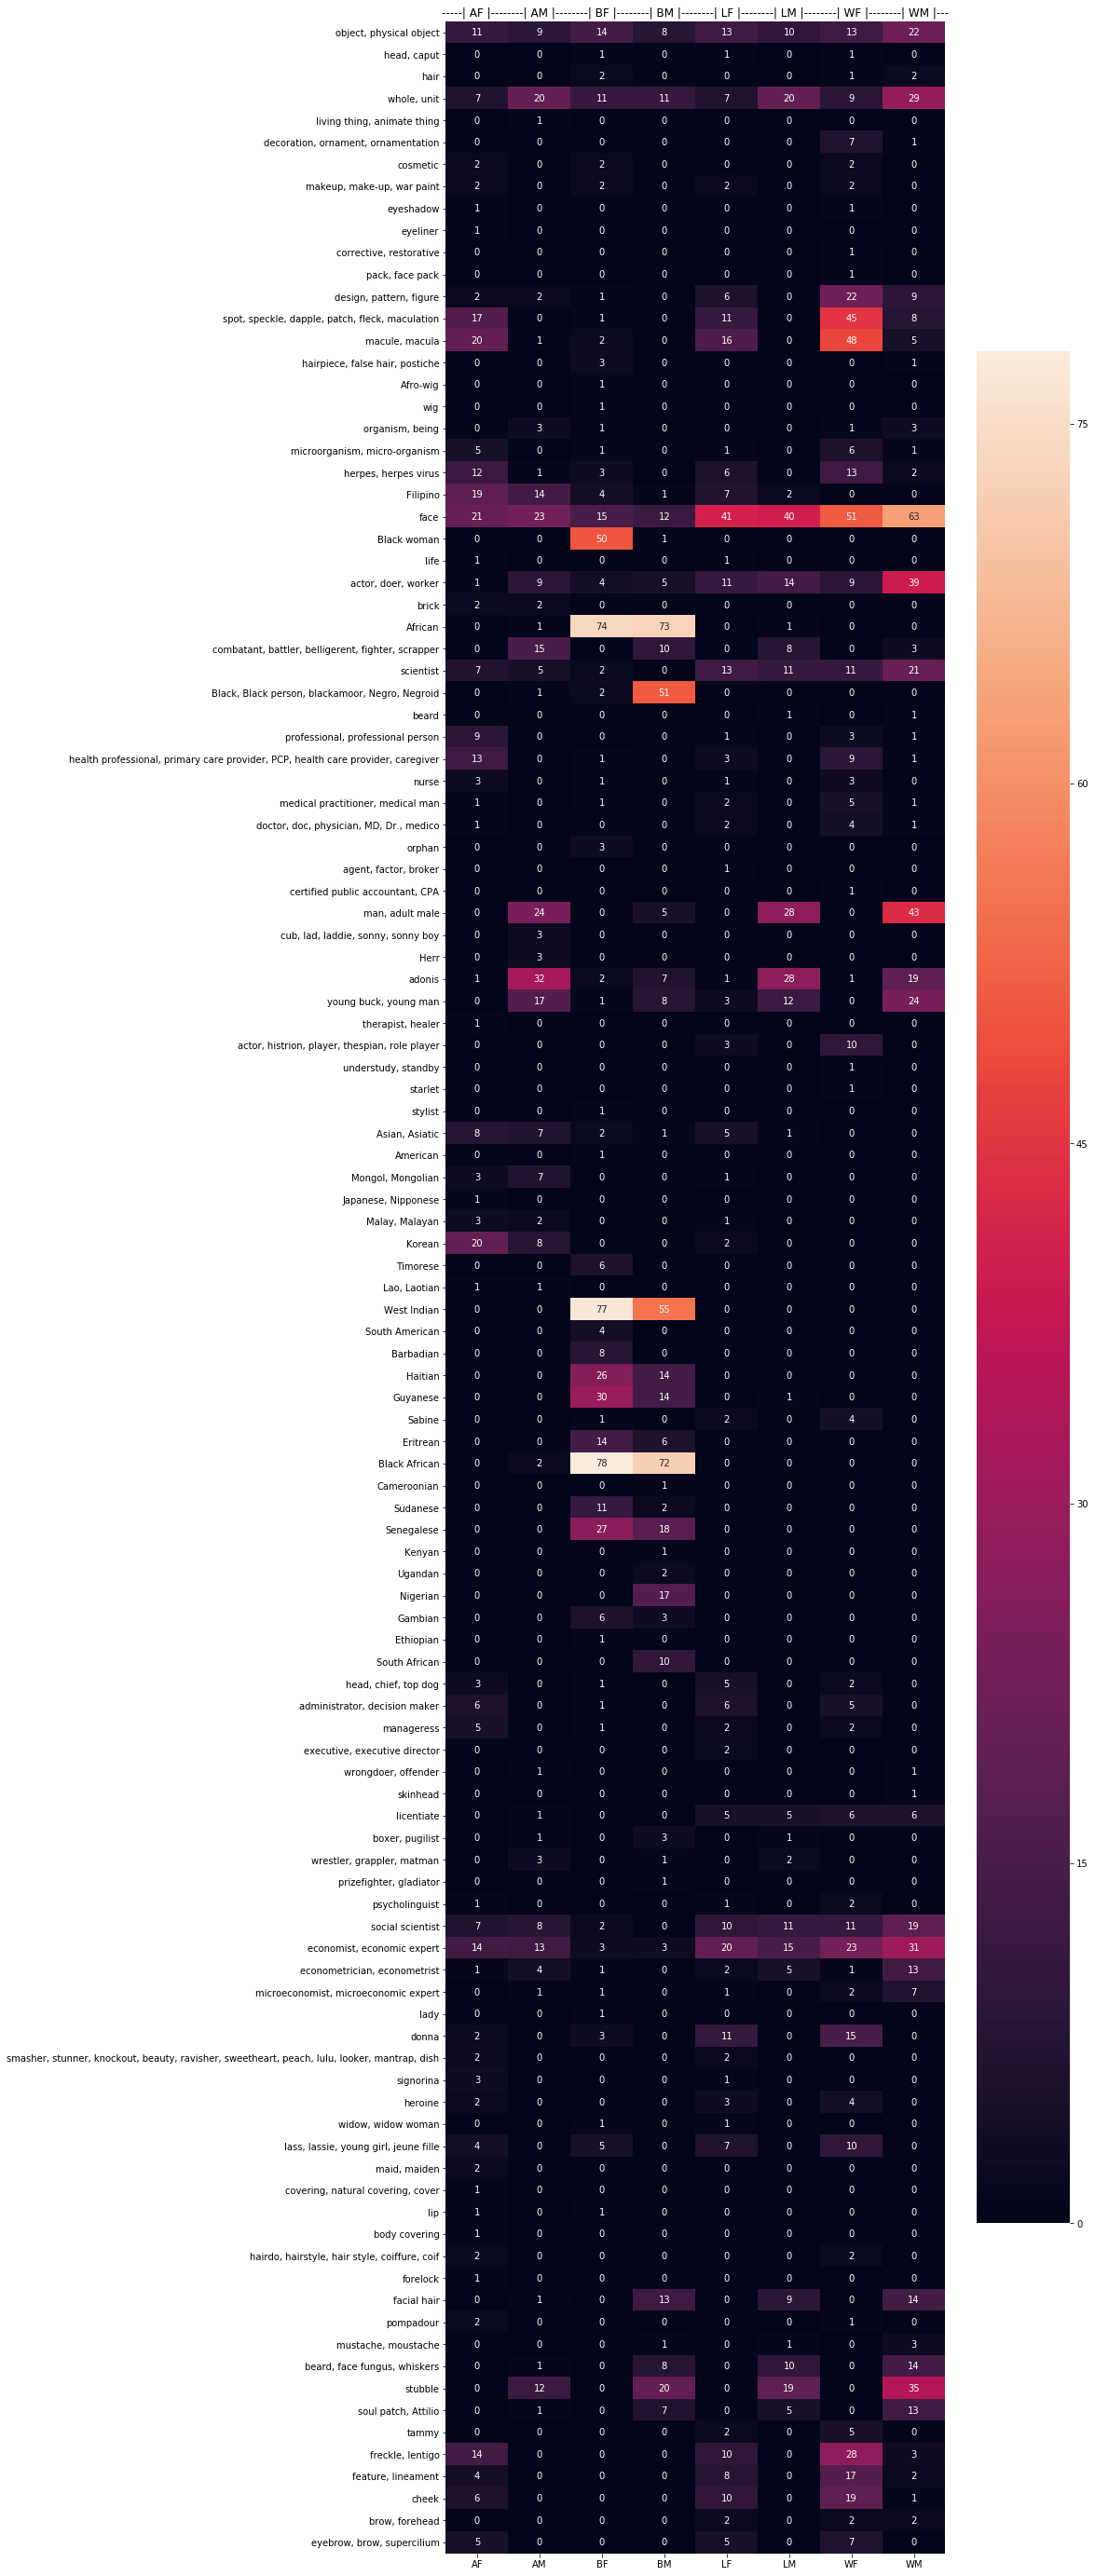

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize = (12,50))
ax = sns.heatmap(CT_top5.T, annot=True, fmt="d")
vc=df_cfd.race_gender.value_counts()
# plt.title(list(zip(vc.index.values,vc.values)))
t=''
for ag in CT_top5.index.values:
    t+=f'-----| {ag} |---' 
print(t)
plt.title(t)
plt.savefig('CT_5_neutral.svg',bbox_inches='tight')

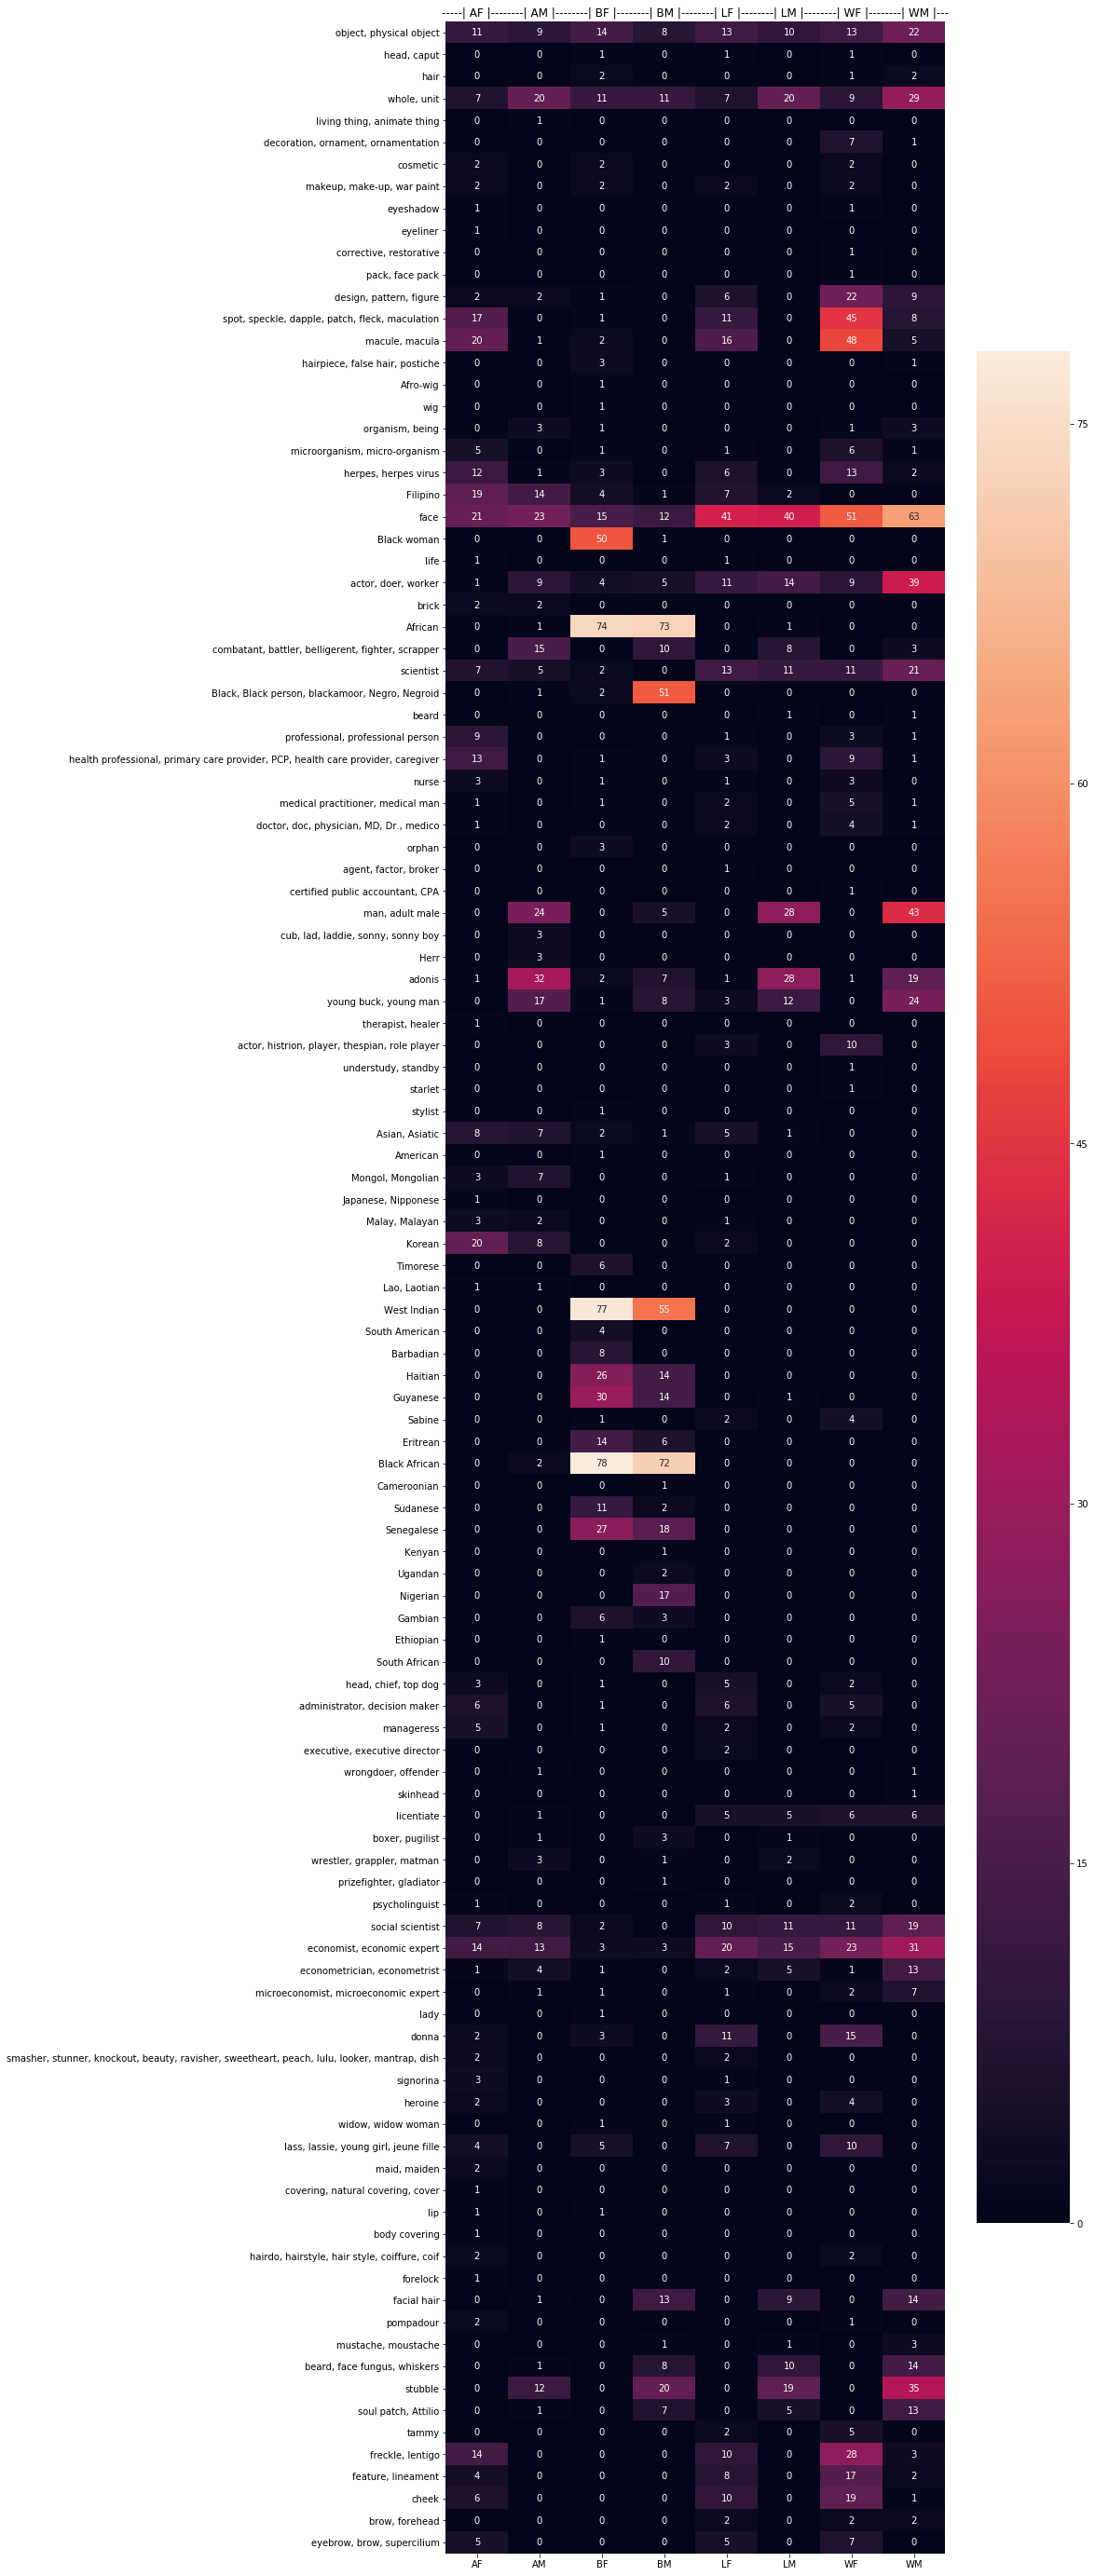

In [44]:
%matplotlib inline
plt.figure(figsize = (12,50))
ax = sns.heatmap(CT_top5.T, annot=True, fmt="d")
vc=df_cfd.race_gender.value_counts()
# plt.title(list(zip(vc.index.values,vc.values)))
plt.title(t)
plt.savefig('CT_5_neutral.pdf',bbox_inches='tight')

In [45]:
CT_top5_cat_norm=deep_copy(CT_top5_categorical)
for c in range(CT_top5_cat_norm.shape[1]):
    CT_top5_cat_norm.iloc[:,c]=CT_top5_cat_norm.iloc[:,c]/CT_top5_cat_norm.iloc[:,c].values.sum()
CT_top5_cat_norm

abstract  clothing  ethno-national  facial-feature   fashion  inanimate  \
AF  0.093525     0.125        0.061867        0.117647  0.108108   0.132075   
AM  0.172662     0.000        0.048369        0.049872  0.027027   0.103774   
BF  0.093525     0.000        0.474691        0.023018  0.135135   0.132075   
BM  0.079137     0.000        0.384702        0.078005  0.000000   0.075472   
LF  0.064748     0.250        0.020247        0.131714  0.108108   0.122642   
LM  0.143885     0.000        0.005624        0.108696  0.000000   0.094340   
WF  0.115108     0.625        0.004499        0.281330  0.472973   0.132075   
WM  0.237410     0.000        0.000000        0.209719  0.148649   0.207547   

     persona  persona-female  persona-male  persona-slur  physiology-related  \
AF  0.214286        0.178082      0.003817      0.304348                 0.1   
AM  0.071429        0.000000      0.301527      0.021739                 0.0   
BF  0.071429        0.123288      0.011450      0.152174                 0.4   
BM  0.000000        0.000000      0.076336      0.000000                 0.0   
LF  0.357143        0.301370      0.015267      0.195652                 0.1   
LM  0.000000        0.000000      0.259542      0.000000                 0.0   
WF  0.142857        0.397260      0.003817      0.282609                 0.2   
WM  0.142857        0.000000      0.328244      0.043478                 0.2   

    profession  
AF    0.120275  
AM    0.103093  
BF    0.032646  
BM    0.039519  
LF    0.147766  
LM    0.123711  
WF    0.187285  
WM    0.245704

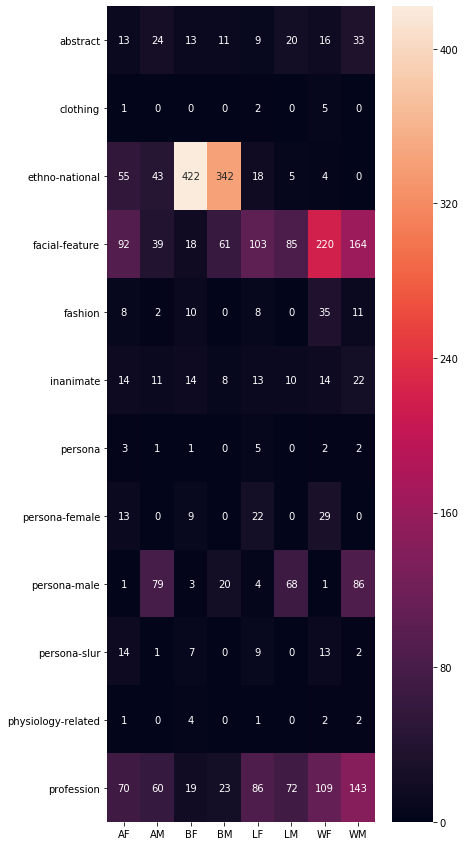

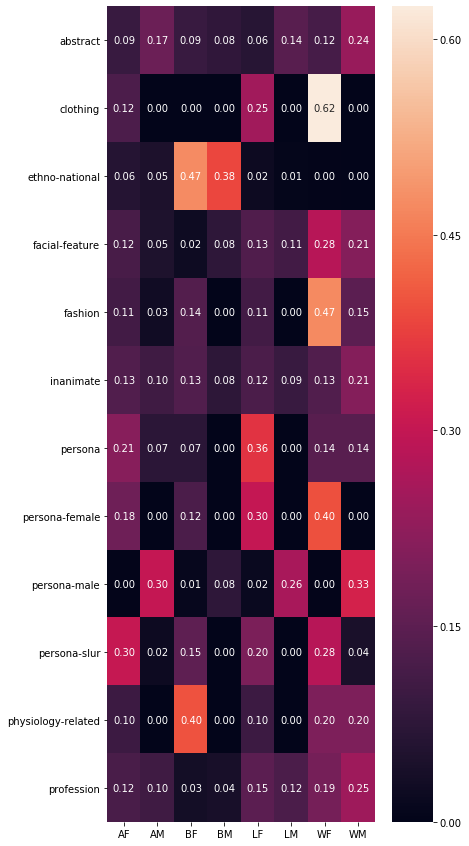

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
plt.figure(figsize = (6,15))
ax = sns.heatmap(CT_top5_categorical.T, annot=True, fmt="d")
plt.savefig('CT_5_cat_neutral.svg',bbox_inches='tight')

###################################################
plt.figure(figsize = (6,15))
ax = sns.heatmap(CT_top5_cat_norm.T, annot=True, fmt=".2f")
plt.savefig('CT_5_cat_norm_neutral.svg',bbox_inches='tight')


# Section-3:  Expression analysis

For all R-G combinations, in how many cases did the softmax vector dramatically change?


In [47]:
rg_vec=df_cfd.race_gender.unique()
expr_vec=df_cfd.exprn.unique()
expr_vec

array(['N', 'F', 'HO', 'HC', 'A'], dtype=object)

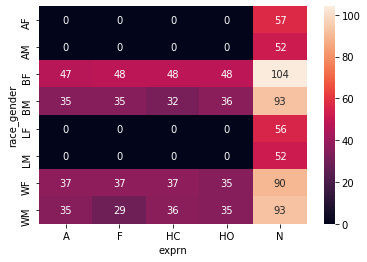

In [50]:
plt.figure(figsize=(6,4))
sns.heatmap(pd.crosstab(df_cfd.race_gender,df_cfd.exprn),annot=True,fmt='d')
save_figure('rg_expr',plt)

0.5600112676620483|BF-009|[149]|[152] 
0.41789358854293823|BF-010|[154]|[157] 
0.42517581582069397|BF-018|[195]|[198] 
0.5183508992195129|BF-024|[219]|[223] 
0.3735385835170746|BF-030|[244]|[247] 
0.44923675060272217|BF-051|[344]|[343] 
0.49213239550590515|BM-015|[444]|[443] 
0.305671751499176|BM-022|[477]|[476] 
0.48929575085639954|BM-037|[540]|[544] 
0.5223917961120605|BM-044|[568]|[571] 
0.6229380369186401|WF-005|[757]|[761] 
0.31217706203460693|WF-008|[772]|[776] 
0.5721010565757751|WF-010|[782]|[785] 
0.4366133511066437|WF-016|[813]|[816] 
0.6192730665206909|WF-026|[862]|[866] 
0.5206756591796875|WF-030|[882]|[884] 
0.6310325860977173|WM-010|[1005]|[1009] 
0.3522438108921051|WM-015|[1030]|[1034] 
0.3257453441619873|WM-029|[1095]|[1094] 
0.3468911647796631|WM-033|[1110]|[1111] 
0.5502557158470154|WM-037|[1127]|[1131] 


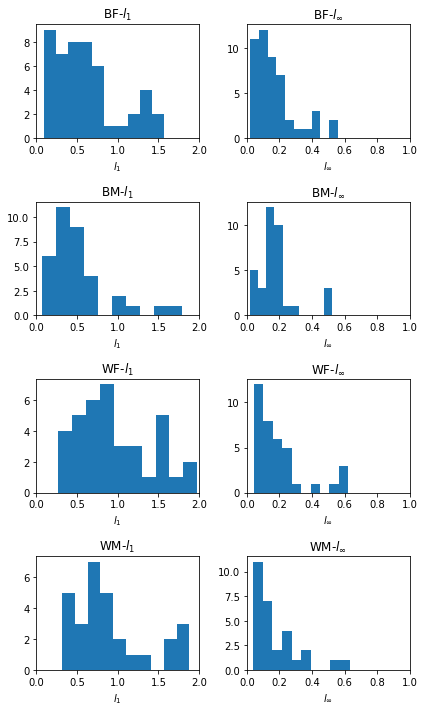

In [51]:
softmax_cfd=softmax(logits_cfd,axis=1)
rg_vec=['BF', 'BM', 'WF', 'WM']
plt.figure(figsize=(6,10))
outlier_imgs=[]

ind_sp=1
for rg in rg_vec:
    
    targets_rg=df_cfd.loc[(df_cfd.race_gender==rg),'Target'].unique()
    ###########
    l1_vec=[]
    l_inf_vec=[]
    ###########
    for user in targets_rg:
        ind_N=np.where((df_cfd.Target==user)&(df_cfd.exprn=='N'))[0]
        ind_other=np.where((df_cfd.Target==user)&(df_cfd.exprn=='F'))[0]
        if(len(ind_other)):
            softmax_N=softmax_cfd[ind_N]
            softmax_other=softmax_cfd[ind_other]
            del_softmax=(softmax_N-softmax_other)[0]
            l1_vec.append(np.linalg.norm(del_softmax,ord=1))
            l_inf_img=np.max(abs(del_softmax))
            l_inf_vec.append(l_inf_img)
            if(l_inf_img>=0.3):
                print(f'{l_inf_img}|{user}|{ind_N}|{ind_other} ')
                outlier_imgs.append(user)
                
    df_=pd.DataFrame(data=np.vstack([l1_vec,l_inf_vec]).T,columns=['l1_distance','l_inf_distance'])
    plt.subplot(4,2,ind_sp)
    plt.hist(l1_vec)
    plt.xlabel('$l_1$')
    plt.title(f'{rg}-$l_1$')
    plt.xlim([0,2])
    plt.subplot(4,2,ind_sp+1)
    plt.hist(l_inf_vec)
    plt.xlim([0,1])
    plt.xlabel('$l_\infty$')
    plt.title(f'{rg}-$l_\infty$')
    ind_sp+=2
plt.tight_layout()
save_figure('l1_linf',plt)

0.5600112676620483|BF-009|[149]|[152]|F 
0.41789358854293823|BF-010|[154]|[157]|F 
0.42517581582069397|BF-018|[195]|[198]|F 
0.5183508992195129|BF-024|[219]|[223]|F 
0.3735385835170746|BF-030|[244]|[247]|F 
0.44923675060272217|BF-051|[344]|[343]|F 
0.49213239550590515|BM-015|[444]|[443]|F 
0.305671751499176|BM-022|[477]|[476]|F 
0.48929575085639954|BM-037|[540]|[544]|F 
0.5223917961120605|BM-044|[568]|[571]|F 
0.6229380369186401|WF-005|[757]|[761]|F 
0.31217706203460693|WF-008|[772]|[776]|F 
0.5721010565757751|WF-010|[782]|[785]|F 
0.4366133511066437|WF-016|[813]|[816]|F 
0.6192730665206909|WF-026|[862]|[866]|F 
0.5206756591796875|WF-030|[882]|[884]|F 
0.6310325860977173|WM-010|[1005]|[1009]|F 
0.3522438108921051|WM-015|[1030]|[1034]|F 
0.3257453441619873|WM-029|[1095]|[1094]|F 
0.3468911647796631|WM-033|[1110]|[1111]|F 
0.5502557158470154|WM-037|[1127]|[1131]|F 
0.38271546363830566|BF-009|[149]|[150]|HO 
0.3199983239173889|BF-020|[204]|[205]|HO 
0.37786808609962463|BM-002|[411]|[409]|

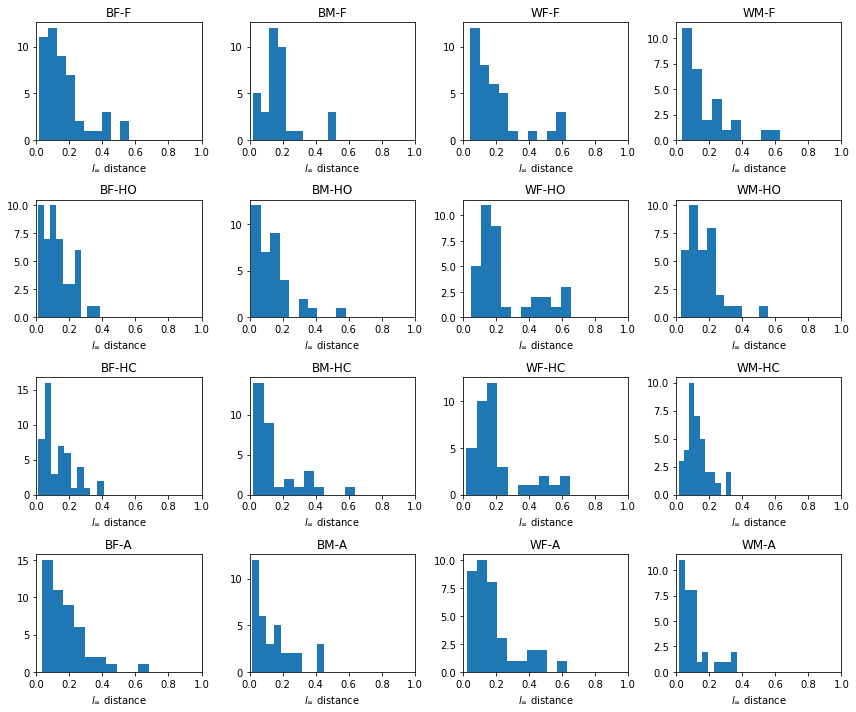

In [52]:
rg_vec=['BF', 'BM', 'WF', 'WM']

outlier_imgs=[]
plt.figure(figsize=(12,10))
ind_sp=1
df_outliers=pd.DataFrame(columns=['target_ID','other_expr','l_infty_softmax','index_Neutral','inf_other_expr']) # A dataframe to catch all the corner cases that show large intra-target-ID softmax variations
for EXPR in ['F', 'HO', 'HC', 'A']:

    outlier_imgs_expr=[]

    
    for rg in rg_vec:

        targets_rg=df_cfd.loc[(df_cfd.race_gender==rg),'Target'].unique()
        ###########
        l1_vec=[]
        l_inf_vec=[]
        ###########
        for user in targets_rg:
            ind_N=np.where((df_cfd.Target==user)&(df_cfd.exprn=='N'))[0]
            ind_other=np.where((df_cfd.Target==user)&(df_cfd.exprn==EXPR))[0]
            if(len(ind_other)):
                softmax_N=softmax_cfd[ind_N]
                softmax_other=softmax_cfd[ind_other]
                del_softmax=(softmax_N-softmax_other)[0]
                l_inf_img=np.max(abs(del_softmax))
                l_inf_vec.append(l_inf_img)
                if(l_inf_img>=0.3):
                    print(f'{l_inf_img}|{user}|{ind_N}|{ind_other}|{EXPR} ')                  
                    df_outliers=df_outliers.append(pd.Series([user,EXPR,np.round(l_inf_img,3),ind_N,ind_other], index=df_outliers.columns ), ignore_index=True)
                    outlier_imgs_expr.append(user)

        plt.subplot(4,4,ind_sp)
        plt.hist(l_inf_vec)
        plt.xlim([0,1])
        plt.xlabel('$l_\infty$ distance')
        plt.title(f'{rg}-{EXPR}')
        ind_sp+=1
        outlier_imgs.append(outlier_imgs_expr)
    plt.tight_layout()
save_figure('l1_expr',plt)
df_outliers.to_csv('df_outliers_expr.csv',index=False)

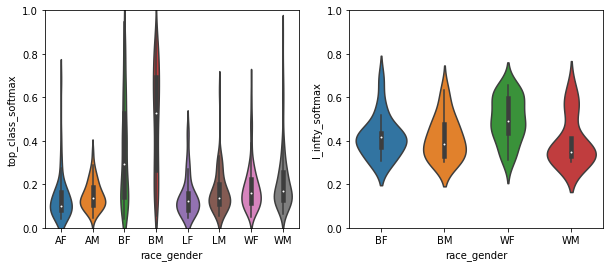

In [53]:
df_outliers['race_gender']=df_outliers.target_ID.apply(lambda x: x.split('-')[0])

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.violinplot(x="race_gender", y="top_class_softmax", data=df_cfd)
plt.ylim([0,1])
plt.subplot(122)
sns.violinplot(x="race_gender", y="l_infty_softmax", data=df_outliers)
plt.ylim([0,1])
save_figure('softmax_l_infty_viloin',plt)

 Let us visualize the worst offenders:

In [54]:
df_worst=df_outliers.sort_values(['l_infty_softmax'],ascending=False).groupby('other_expr').head(2).sort_values(['other_expr'],ascending=True)
df_worst

target_ID other_expr  l_infty_softmax index_Neutral inf_other_expr  \
58    BF-008          A            0.682         [144]          [147]   
68    WF-005          A            0.629         [757]          [760]   
16    WM-010          F            0.631        [1005]         [1009]   
10    WF-005          F            0.623         [757]          [761]   
49    WF-005         HC            0.647         [757]          [759]   
42    BM-002         HC            0.636         [411]          [410]   
29    WF-005         HO            0.655         [757]          [758]   
34    WF-026         HO            0.619         [862]          [864]   

   race_gender  
58          BF  
68          WF  
16          WM  
10          WF  
49          WF  
42          BM  
29          WF  
34          WF

BF-008
WF-005
WM-010
BM-002
WF-026


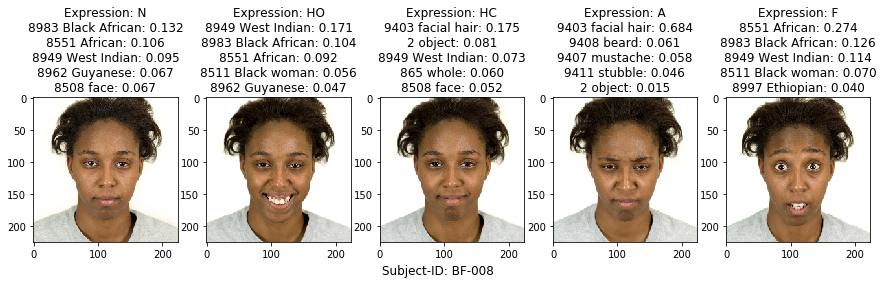

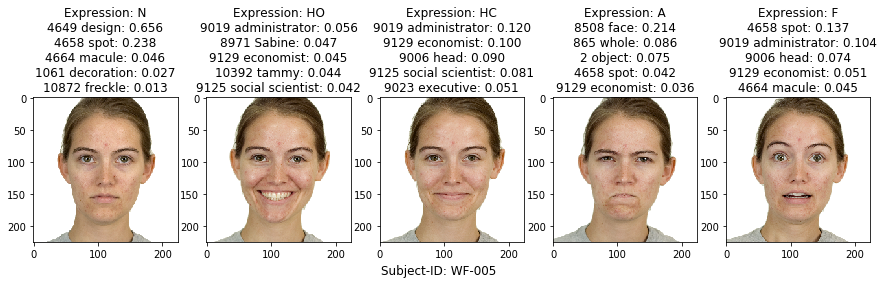

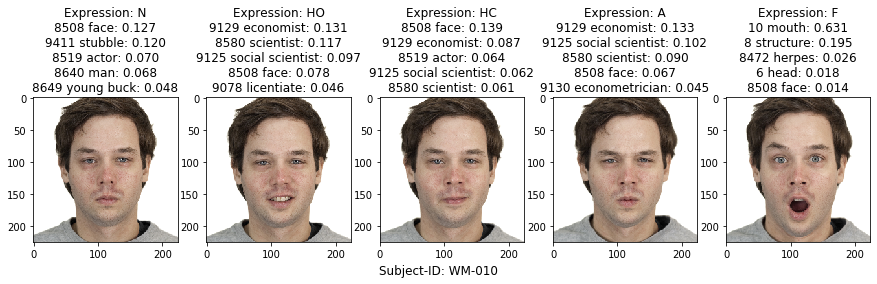

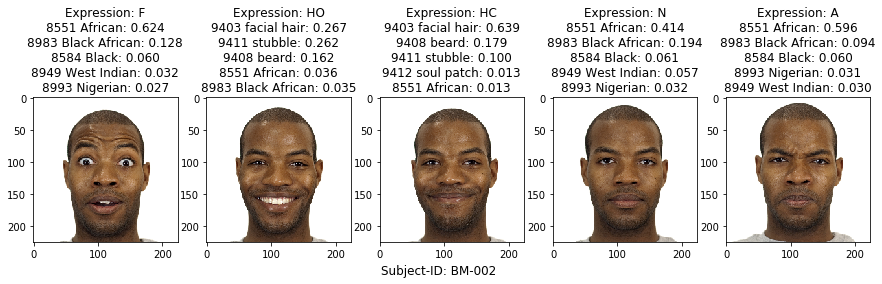

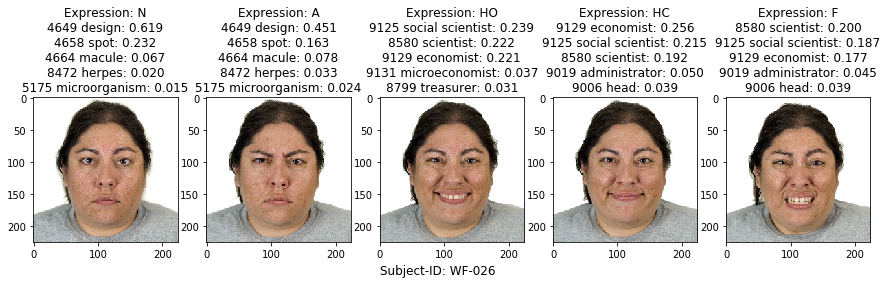

In [55]:
for target in df_worst.target_ID.unique():
    print(target)
    _=fetch_results(target,df_cfd)

In [56]:
# !pip install version_information
%load_ext version_information
ver=%version_information

from pip._internal.operations.freeze import freeze
for requirement in freeze(local_only=True):
    print(requirement)
ver

absl-py==0.8.1
alembic==1.3.1
argcomplete==1.10.2
argh==0.26.2
asn1crypto==1.2.0
astor==0.8.0
async-generator==1.10
attrs==19.3.0
backcall==0.1.0
bleach==1.5.0
blinker==1.4
boto==2.49.0
boto3==1.10.21
botocore==1.13.22
cachetools==4.0.0
certifi==2019.11.28
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
conda-package-handling==1.6.0
configparser==4.0.2
cryptography==2.8
cudf==0.9.0
cugraph==0.9.0+0.g846190c.dirty
cuml==0.9.1
cupy==6.3.0
cycler==0.10.0
Cython==0.29.14
cytoolz==0.10.1
dask==2.8.0
databricks-cli==0.9.1
decorator==4.4.1
defusedxml==0.6.0
dill==0.2.7.1
docker==4.1.0
docker-pycreds==0.4.0
docutils==0.15.2
entrypoints==0.3
fastavro==0.22.7
fastcache==1.1.0
fastrlock==0.4
Flask==1.1.1
future==0.18.2
gast==0.2.2
gitdb2==2.0.6
GitPython==3.0.5
gmpy2==2.0.8
google-auth==1.10.0
google-auth-oauthlib==0.4.1
google-pasta==0.1.8
gorilla==0.3.0
gql==0.1.0
graphql-core==2.2.1
grpcio==1.16.1
gunicorn==20.0.0
h5py==2.9.0
html5lib==0.9999999
idna==2.8
imageio==2.6.

Software versions
Python 3.6.9 64bit [GCC 7.3.0]
IPython 7.9.0
OS Linux 5.3.0 53 generic x86_64 with debian buster sid
Tue Sep 08 19:08:15 2020 UTC